In [1]:
!pip -q install geopandas


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

## Airlines data

we analyze both market and segment, using segment https://transportation.libanswers.com/faq/166158

In [4]:
import os

DATA_ROOT = 'data'

domestic_flights = pd.read_csv(os.path.join(DATA_ROOT, 'T_T100D_SEGMENT_ALL_CARRIER.csv'))
domestic_flights = domestic_flights[domestic_flights['DEPARTURES_PERFORMED'] > 0]
domestic_flights = domestic_flights[domestic_flights['PASSENGERS'] > 0]
domestic_flights = domestic_flights[domestic_flights['DISTANCE'] > 0]
domestic_flights = domestic_flights[domestic_flights['RAMP_TO_RAMP'] > 0]
domestic_flights.columns = domestic_flights.columns.str.lower()

domestic_flights.head()

departures_performed  seats  passengers  distance  ramp_to_ramp  \
12753                   1.0    0.0         1.0    1107.0         151.0   
12754                   1.0    0.0         1.0    1107.0         156.0   
13364                   1.0    1.0         1.0       9.0          11.0   
13365                   1.0    1.0         1.0       9.0          12.0   
13366                   1.0    1.0         1.0      11.0          13.0   

      unique_carrier  airline_id                   unique_carrier_name  \
12753            AMQ       20201                   Ameristar Air Cargo   
12754            AMQ       20201                   Ameristar Air Cargo   
13364             7S       20330  Ryan Air f/k/a Arctic Transportation   
13365             7S       20330  Ryan Air f/k/a Arctic Transportation   
13366             7S       20330  Ryan Air f/k/a Arctic Transportation   

      carrier                          carrier_name  origin_airport_id origin  \
12753     AMQ                   Ameristar Air Cargo              11697    FLL   
12754     AMQ                   Ameristar Air Cargo              15024    STT   
13364      7S  Ryan Air f/k/a Arctic Transportation              14493    RDV   
13365      7S  Ryan Air f/k/a Arctic Transportation              14880    SLQ   
13366      7S  Ryan Air f/k/a Arctic Transportation              10996    CHU   

      origin_state_abr  dest_airport_id dest dest_state_abr  aircraft_type  \
12753               FL            15024  STT             VI            635   
12754               VI            11697  FLL             FL            635   
13364               AK            14880  SLQ             AK             35   
13365               AK            14493  RDV             AK             35   
13366               AK            10304  ANI             AK             35   

       year  quarter  month  
12753  2019        4     10  
12754  2019        4     10  
13364  2019        3      8  
13365  2019        2      5  
13366  2019        4     11

In [5]:
domestic_flights.describe()

departures_performed          seats     passengers       distance  \
count         322093.000000  322093.000000  322093.000000  322093.000000   
mean              26.947540    3090.670521    2548.013471     751.648729   
std               40.720759    5408.373353    4560.157768     611.161368   
min                1.000000       0.000000       1.000000       1.000000   
25%                2.000000     173.000000     124.000000     292.000000   
50%               11.000000    1120.000000     880.000000     612.000000   
75%               32.000000    3960.000000    3205.000000    1032.000000   
max             1053.000000  108032.000000   86623.000000    7264.000000   

        ramp_to_ramp     airline_id  origin_airport_id  dest_airport_id  \
count  322093.000000  322093.000000      322093.000000    322093.000000   
mean     3415.480852   20176.283033       12755.161720     12747.881963   
std      5529.337651     475.043082        1562.388145      1560.590119   
min         5.000000   19393.000000       10005.000000     10005.000000   
25%       209.000000   19805.000000       11292.000000     11292.000000   
50%      1278.000000   20304.000000       12889.000000     12889.000000   
75%      4668.000000   20409.000000       14100.000000     14100.000000   
max    140068.000000   21974.000000       16876.000000     16875.000000   

       aircraft_type      year        quarter          month  
count  322093.000000  322093.0  322093.000000  322093.000000  
mean      616.597023    2019.0       2.516754       6.559525  
std       159.861747       0.0       1.115596       3.446743  
min        10.000000    2019.0       1.000000       1.000000  
25%       614.000000    2019.0       2.000000       4.000000  
50%       638.000000    2019.0       3.000000       7.000000  
75%       694.000000    2019.0       4.000000      10.000000  
max       889.000000    2019.0       4.000000      12.000000

In [6]:
airports = pd.read_csv(os.path.join(DATA_ROOT, 'airports.csv'))
airports = airports[['name', 'city', 'country', 'iata', 'lat', 'lon']]
airports.head()

name          city  \
0                               Goroka Airport        Goroka   
1                               Madang Airport        Madang   
2                 Mount Hagen Kagamuga Airport   Mount Hagen   
3                               Nadzab Airport        Nadzab   
4  Port Moresby Jacksons International Airport  Port Moresby   

            country iata       lat         lon  
0  Papua New Guinea  GKA -6.081690  145.391998  
1  Papua New Guinea  MAG -5.207080  145.789001  
2  Papua New Guinea  HGU -5.826790  144.296005  
3  Papua New Guinea  LAE -6.569803  146.725977  
4  Papua New Guinea  POM -9.443380  147.220001

In [7]:
domestic_flights = pd.merge(domestic_flights, airports, left_on='origin', right_on='iata', how='left')
domestic_flights = pd.merge(domestic_flights, airports, left_on='dest', right_on='iata', how='left', suffixes=('_origin', '_dest'))
domestic_flights.head()

departures_performed  seats  passengers  distance  ramp_to_ramp  \
0                   1.0    0.0         1.0    1107.0         151.0   
1                   1.0    0.0         1.0    1107.0         156.0   
2                   1.0    1.0         1.0       9.0          11.0   
3                   1.0    1.0         1.0       9.0          12.0   
4                   1.0    1.0         1.0      11.0          13.0   

  unique_carrier  airline_id                   unique_carrier_name carrier  \
0            AMQ       20201                   Ameristar Air Cargo     AMQ   
1            AMQ       20201                   Ameristar Air Cargo     AMQ   
2             7S       20330  Ryan Air f/k/a Arctic Transportation      7S   
3             7S       20330  Ryan Air f/k/a Arctic Transportation      7S   
4             7S       20330  Ryan Air f/k/a Arctic Transportation      7S   

                           carrier_name  ...  country_origin iata_origin  \
0                   Ameristar Air Cargo  ...   United States         FLL   
1                   Ameristar Air Cargo  ...  Virgin Islands         STT   
2  Ryan Air f/k/a Arctic Transportation  ...             NaN         NaN   
3  Ryan Air f/k/a Arctic Transportation  ...   United States         SLQ   
4  Ryan Air f/k/a Arctic Transportation  ...   United States         CHU   

  lat_origin  lon_origin                                        name_dest  \
0  26.072599  -80.152702                            Cyril E. King Airport   
1  18.337299  -64.973396  Fort Lauderdale Hollywood International Airport   
2        NaN         NaN                                Sleetmute Airport   
3  61.700500 -157.166000                                              NaN   
4  61.579102 -159.216003                                    Aniak Airport   

         city_dest    country_dest  iata_dest   lat_dest    lon_dest  
0       St. Thomas  Virgin Islands        STT  18.337299  -64.973396  
1  Fort Lauderdale   United States        FLL  26.072599  -80.152702  
2        Sleetmute   United States        SLQ  61.700500 -157.166000  
3              NaN             NaN        NaN        NaN         NaN  
4            Aniak   United States        ANI  61.581600 -159.542999  

[5 rows x 32 columns]

In [8]:
# dropping flights that are not within the US (samoa, puerto rico, etc.)

domestic_flights = domestic_flights[domestic_flights['country_origin'] == 'United States']
domestic_flights = domestic_flights[domestic_flights['country_dest'] == 'United States']

In [9]:
domestic_flights = domestic_flights.dropna(subset=['lat_origin', 'lon_origin', 'lat_dest', 'lon_dest'])
domestic_flights.rename(columns={'origin': 'airport_origin', 'dest': 'airport_dest'}, inplace=True)

In [10]:
"""# converting sched_dep_time to 'std' - Scheduled time of departure
airlines_full['std'] = airlines_full.dep_time.astype(str).str[:2] + ':' + airlines_full.dep_time.astype(str).str[2:4] + ':00'

# converting sched_arr_time to 'sta' - Scheduled time of arrival
airlines_full['sta'] = airlines_full.arr_time.astype(str).str[:2] + ':' + airlines_full.arr_time.astype(str).str[2:4] + ':00'

# date
airlines_full['date'] = pd.to_datetime(airlines_full[['year', 'month', 'day']])

# dropping the year, month and day columns
airlines_full.drop(['year', 'month', 'day'], axis=1, inplace=True)""";

In [11]:
print('unique airports origin: ', len(domestic_flights['airport_origin'].unique()))
print('unique airports destination: ', len(domestic_flights['airport_dest'].unique()))

unique airports origin:  826
unique airports destination:  820


In [12]:
domestic_flights.groupby(['airport_origin', 'airport_dest']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(10)

airport_origin airport_dest  count
9258             LAS          LAX    322
9441             LAX          LAS    319
15954            SFO          LAX    308
9507             LAX          SFO    307
4608             DEN          LAX    263
12761            ORD          MSP    257
11697            MSP          ORD    254
9401             LAX          DEN    248
8371             IND          ORD    242
12618            ORD          ATL    241

In [13]:
# group by origin and destination and sum the passengers and departures_performed, keeping lon_origin, domestic_flights.lat_origin, domestic_flights.lon_dest, domestic_flights.lat_dest
aggregated_domestic_flights = domestic_flights.groupby(['airport_origin', 'airport_dest', 'month']).agg({'passengers': 'sum', 'departures_performed': 'sum', 'ramp_to_ramp': 'mean', 'lat_origin': 'first', 'lon_origin': 'first', 'lat_dest': 'first', 'lon_dest': 'first'}).reset_index()

In [14]:
aggregated_domestic_flights['passengers_log'] = np.log(aggregated_domestic_flights['passengers'])
aggregated_domestic_flights['departures_performed_log'] = np.log(aggregated_domestic_flights['departures_performed'])
aggregated_domestic_flights['passengers_per_departure'] = aggregated_domestic_flights['passengers'] / aggregated_domestic_flights['departures_performed']

In [15]:
aggregated_domestic_flights['ramp_to_ramp'] = aggregated_domestic_flights['ramp_to_ramp'] / aggregated_domestic_flights['departures_performed']

In [16]:
aggregated_domestic_flights.describe()

month     passengers  departures_performed  ramp_to_ramp  \
count  98601.000000   98601.000000          98601.000000  98601.000000   
mean       6.544132    8204.148700             85.237553     84.468094   
std        3.417599   14616.055302            118.757911    322.381930   
min        1.000000       1.000000              1.000000      0.987013   
25%        4.000000     178.000000              8.000000     26.467816   
50%        7.000000    2861.000000             46.000000     55.215385   
75%        9.000000    8973.000000            114.000000    103.116279   
max       12.000000  166448.000000           1526.000000  24522.000000   

         lat_origin    lon_origin      lat_dest      lon_dest  passengers_log  \
count  98601.000000  98601.000000  98601.000000  98601.000000    98601.000000   
mean      39.424024    -99.170037     39.399939    -99.120000        7.179184   
std        9.229224     24.780134      9.216887     24.710928        2.655065   
min       19.721399   -176.645996     19.721399   -176.645996        0.000000   
25%       33.636700   -112.012001     33.636700   -112.012001        5.181784   
50%       38.944500    -90.258003     38.852100    -90.258003        7.958926   
75%       41.978600    -81.237503     41.978600    -81.237503        9.101975   
max       71.285402    -68.044800     71.285402    -68.044800       12.022438   

       departures_performed_log  passengers_per_departure  
count              98601.000000              98601.000000  
mean                   3.261770                 82.717747  
std                    1.918564                 55.053035  
min                    0.000000                  0.076923  
25%                    2.079442                 39.583333  
50%                    3.828641                 75.604317  
75%                    4.736198                131.741935  
max                    7.330405                374.000000

In [17]:
aggregated_domestic_flights[aggregated_domestic_flights['passengers_per_departure'] < 1]

airport_origin airport_dest  month  passengers  departures_performed  \
806              ACK          LGA      1         1.0                   2.0   
837              ACK          OWD      6         9.0                  12.0   
1118             ADQ          AKN      7         3.0                  11.0   
1162             ADQ          KYK      2        12.0                  13.0   
1568             AKI          RSH      4         1.0                   2.0   
...              ...          ...    ...         ...                   ...   
98091            WSN          AKN     12         3.0                   7.0   
98093            WSN          ANC      6         2.0                   3.0   
98111            WSN          EGX      1         1.0                   2.0   
98113            WSN          EGX      7         5.0                   6.0   
98114            WSN          IGG      4         1.0                   2.0   

       ramp_to_ramp  lat_origin  lon_origin   lat_dest    lon_dest  \
806      128.000000   41.253101  -70.060204  40.777199  -73.872597   
837       50.000000   41.253101  -70.060204  42.190498  -71.172897   
1118      40.045455   57.750000 -152.494003  58.676800 -156.649002   
1162      12.897436   57.750000 -152.494003  57.567101 -154.449997   
1568      36.500000   60.902901 -161.231003  61.778885 -161.319458   
...             ...         ...         ...        ...         ...   
98091     13.428571   58.703400 -157.007996  58.676800 -156.649002   
98093     77.666667   58.703400 -157.007996  61.174400 -149.996002   
98111     20.000000   58.703400 -157.007996  58.185501 -157.375000   
98113     25.333333   58.703400 -157.007996  58.185501 -157.375000   
98114     30.500000   58.703400 -157.007996  59.324001 -155.901993   

       passengers_log  departures_performed_log  passengers_per_departure  
806          0.000000                  0.693147                  0.500000  
837          2.197225                  2.484907                  0.750000  
1118         1.098612                  2.397895                  0.272727  
1162         2.484907                  2.564949                  0.923077  
1568         0.000000                  0.693147                  0.500000  
...               ...                       ...                       ...  
98091        1.098612                  1.945910                  0.428571  
98093        0.693147                  1.098612                  0.666667  
98111        0.000000                  0.693147                  0.500000  
98113        1.609438                  1.791759                  0.833333  
98114        0.000000                  0.693147                  0.500000  

[469 rows x 13 columns]

In [18]:
# lon_origin and lon_dest < 0
aggregated_domestic_flights = aggregated_domestic_flights[aggregated_domestic_flights['lon_origin'] < 0]
aggregated_domestic_flights = aggregated_domestic_flights[aggregated_domestic_flights['lon_dest'] < 0]

In [19]:
# aggregated_domestic_flights = aggregated_domestic_flights[aggregated_domestic_flights['passengers_per_departure'] > 1]

## Graph analysis

In [20]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl

# create geopandas dataframe from airlines_full
gdf = gpd.GeoDataFrame(domestic_flights, geometry=gpd.points_from_xy(domestic_flights.lon_origin, domestic_flights.lat_origin))

# create column with coordinates of destination airport geometry
gdf['geometry_dest'] = gpd.points_from_xy(gdf.lon_dest, gdf.lat_dest)
# create movement id for each flight
gdf['movement_id'] = gdf.index + 1

In [21]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl

# create geopandas dataframe from airlines_full
gdf = gpd.GeoDataFrame(aggregated_domestic_flights, geometry=gpd.points_from_xy(aggregated_domestic_flights.lon_origin, aggregated_domestic_flights.lat_origin))

# create column with coordinates of destination airport geometry
gdf['geometry_dest'] = gpd.points_from_xy(gdf.lon_dest, gdf.lat_dest)
# create movement id for each flight
gdf['movement_id'] = gdf.index + 1

In [22]:
def get_weighted_network(network):
    """ 
    Extract edges for a particular year from
    a MultiGraph. The edge is also populated with
    two attributes, weight and weight_inv where
    weight is the number of passengers and
    weight_inv the inverse of it.
    """
    weighted_network = nx.DiGraph()
    for edge in network.edges:
        source, target, _ = edge
        attr = network[source][target]
        passengers = sum([attr[i]['passengers'] for i in attr])
        departures_performed = sum([attr[i]['departures_performed'] for i in attr])
        weighted_network.add_edge(
            source, target,
            passengers=passengers,
            passengers_log=np.log(passengers),
            passengers_inv=1/(passengers if passengers != 0.0 else 1),
            departures_performed=departures_performed,
            departures_performed_log=np.log(departures_performed),
            ramp_to_ramp=np.mean([attr[i]['ramp_to_ramp'] for i in attr]),
            )
    return weighted_network


In [23]:
passenger_graph = nx.from_pandas_edgelist(
    gdf, 
    source='airport_origin',
    target='airport_dest',
    edge_key='month',
    edge_attr=['passengers', 'departures_performed', 'ramp_to_ramp'],
    create_using=nx.MultiDiGraph())

In [24]:
weighted_net = get_weighted_network(passenger_graph)

In [25]:
edges = gdf[['airport_origin', 'airport_dest']].values

spatial_network = nx.from_edgelist(edges)

print(f'Number of nodes in the spatial network: {len(spatial_network.nodes())}')
print(f'Number of edges in the spatial network: {len(spatial_network.edges())}')
print(f'Spatial network density: {nx.density(spatial_network)}')
print()
print(f'The spatial network is directed: {nx.is_directed(spatial_network)}')

Number of nodes in the spatial network: 844
Number of edges in the spatial network: 11644
Spatial network density: 0.03273121834117601

The spatial network is directed: False


In [26]:
print(f'Number of nodes in the spatial network: {len(weighted_net.nodes())}')
print(f'Number of edges in the spatial network: {len(weighted_net.edges())}')
print(f'Spatial network density: {nx.density(weighted_net)}')
print()
print(f'The spatial network is directed: {nx.is_directed(weighted_net)}')

Number of nodes in the spatial network: 844
Number of edges in the spatial network: 18487
Spatial network density: 0.025983426377246686

The spatial network is directed: True


In [27]:
spatial_network = weighted_net

In [28]:
pos = {v['iata']: (v['lon'], v['lat'])
       for _, v in
       airports.to_dict('index').items()}

labels = {iata: '' 
          for iata in spatial_network.nodes}

### Degree centrality

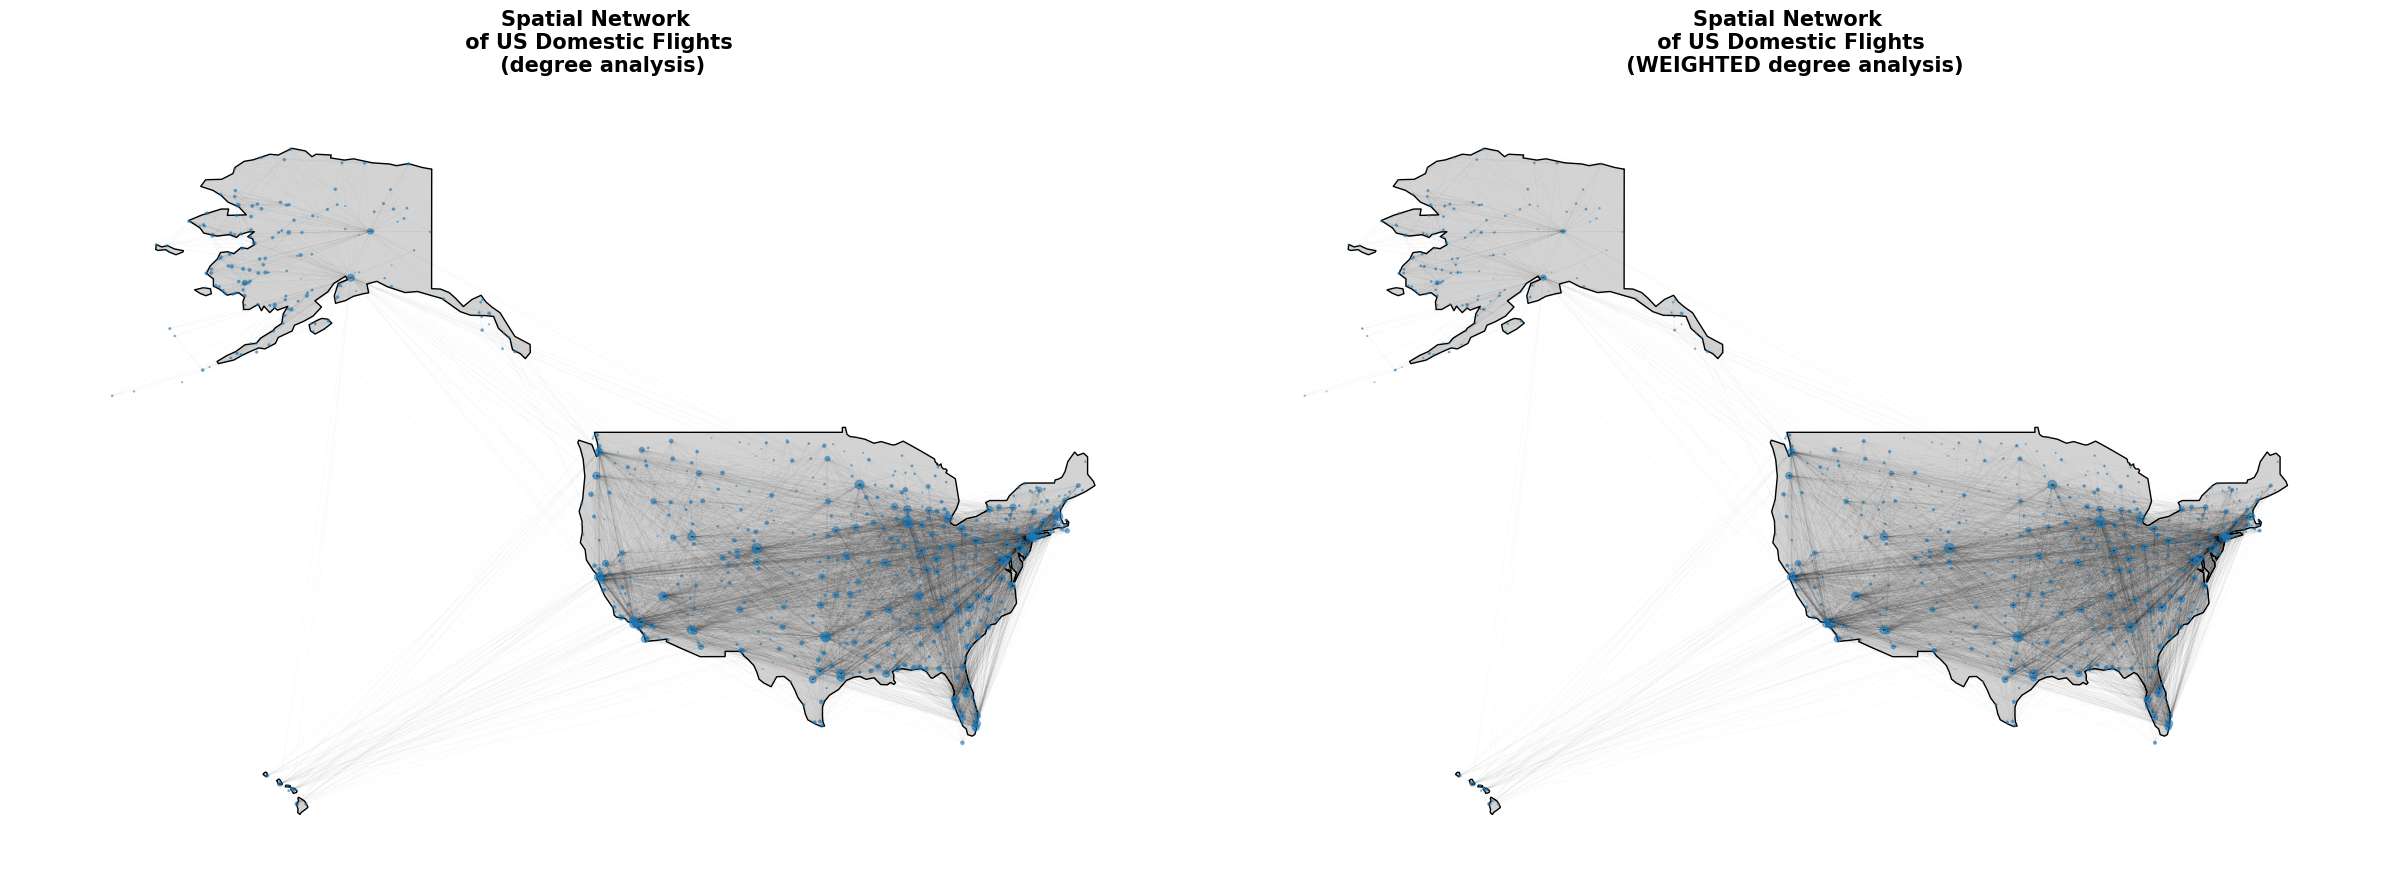

In [29]:
from metrics import get_nodes_degree_centrality

deg_cent = get_nodes_degree_centrality(spatial_network)
deg_sizes = [deg_cent[iata] * 50 for iata in spatial_network.nodes]

fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(1, 2, 1)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=deg_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('Spatial Network \n of US Domestic Flights \n (degree analysis)', fontsize=15, fontweight='bold')

deg_cent = get_nodes_degree_centrality(spatial_network, weight='passengers_log')
deg_sizes = [deg_cent[iata] * 50 for iata in spatial_network.nodes]

ax = fig.add_subplot(1, 2, 2)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=deg_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('Spatial Network \n of US Domestic Flights \n (WEIGHTED degree analysis)', fontsize=15, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

In [30]:
def get_passengers_sizes(passengers_nums):
    passengers_sizes = []
    for iata in spatial_network.nodes:
        passengers_sizes.append(passengers_nums[passengers_nums['airport'] == iata]['passengers'].values)

    passengers_sizes = [row[0] if len(row) > 0 else 0 for row in passengers_sizes]

    # passengers_sizes = [size / max(passengers_sizes) * 50 for size in passengers_sizes]
    return passengers_sizes

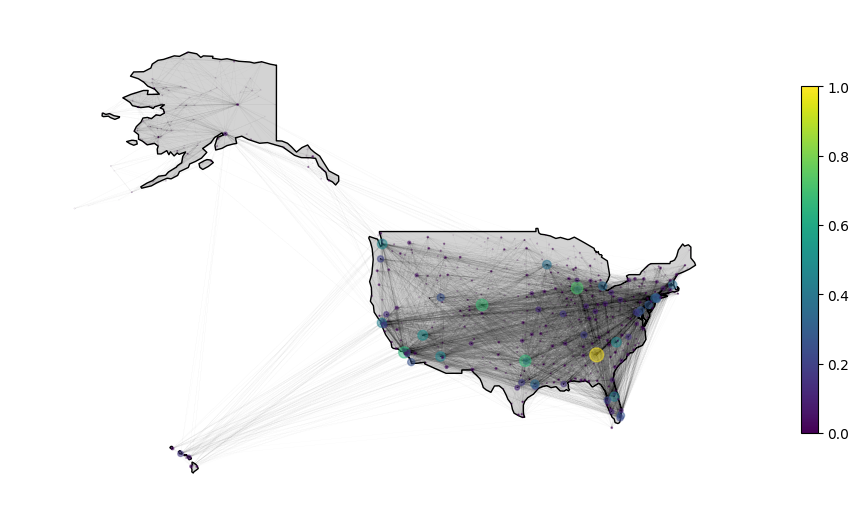

In [31]:
# Map projection
fig, ax = plt.subplots(figsize=(12, 9))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter data for the United States
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

passengers_departures = domestic_flights.groupby('airport_origin')['passengers'].sum().reset_index().rename(columns={'airport_origin': 'airport'})
passengers_arrivals = domestic_flights.groupby('airport_dest')['passengers'].sum().reset_index().rename(columns={'airport_dest': 'airport'})

passengers_sizes_departures = get_passengers_sizes(passengers_departures)
passengers_sizes_arrivales = get_passengers_sizes(passengers_arrivals)

passengers_sizes = [dep + arr for dep, arr in zip(passengers_sizes_departures, passengers_sizes_arrivales)]
passengers_sizes = [size / max(passengers_sizes) * 100 for size in passengers_sizes]

nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.01,
                 node_size=passengers_sizes,
                 node_color=passengers_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=mpl.colormaps['viridis'])

# Customize the plot appearance
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
# Show the plot
plt.show()

In [32]:
passengers_departures = domestic_flights.groupby('airport_origin')['passengers'].sum().reset_index().rename(columns={'airport_origin': 'airport'})
passengers_arrivals = domestic_flights.groupby('airport_dest')['passengers'].sum().reset_index().rename(columns={'airport_dest': 'airport'})

total_passengers = pd.merge(passengers_departures, passengers_arrivals, on='airport')
total_passengers['total_passengers'] = total_passengers['passengers_x'] + total_passengers['passengers_y']
total_passengers = total_passengers[['airport', 'total_passengers']]
total_passengers = total_passengers.sort_values('total_passengers', ascending=False)
total_passengers.reset_index(drop=True, inplace=True)
total_passengers['total_passengers'] = total_passengers['total_passengers'] / total_passengers['total_passengers'].max()
total_passengers['airport_name'] = total_passengers['airport'].apply(lambda x: airports[airports['iata'] == x]['name'].values[0])

total_passengers = total_passengers[['airport_name', 'airport', 'total_passengers']]
total_passengers.head(10)

airport_name airport  total_passengers
0  Hartsfield Jackson Atlanta International Airport     ATL          1.000000
1              Chicago O'Hare International Airport     ORD          0.719263
2                      Denver International Airport     DEN          0.682699
3           Dallas Fort Worth International Airport     DFW          0.659601
4                 Los Angeles International Airport     LAX          0.645973
5                    McCarran International Airport     LAS          0.488996
6           Charlotte Douglas International Airport     CLT          0.471989
7              Seattle Tacoma International Airport     SEA          0.470870
8          Phoenix Sky Harbor International Airport     PHX          0.456618
9               San Francisco International Airport     SFO          0.431990

## Metrics

### In degree centrality

capire bene che cosa vuol dire questa cosa

e.g. 

In temporal graphs, nodes with high weighted in-degree and out-degree
are likely to correspond to areas of high traffic congestion. Specifically, high in-degree
nodes indicate areas that are the destination of many travelers, while high out-degree
nodes indicate areas that are the origin of many travels.


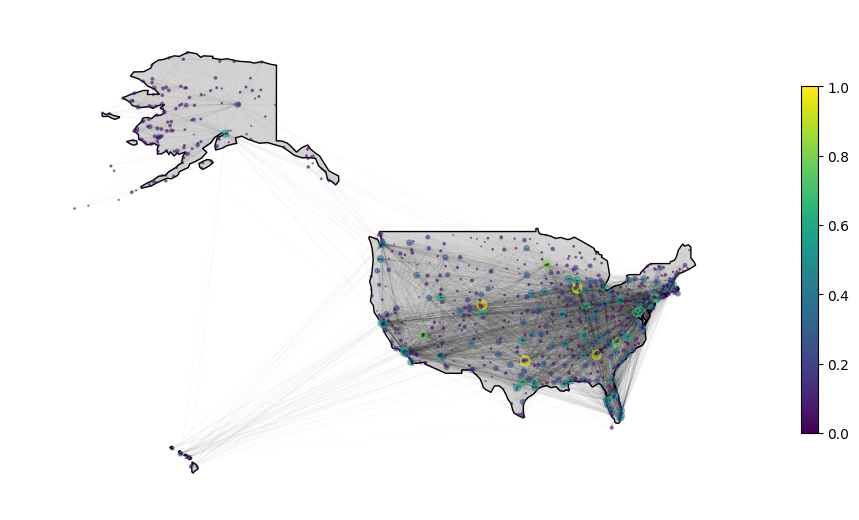

In [33]:
from metrics import get_nodes_in_degree_centrality

# Map projection
fig, ax = plt.subplots(figsize=(12, 9))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter data for the United States
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

# get nodes in degree centrality for the network 

directed_network = nx.DiGraph(spatial_network)
nodes_in_degree_centrality = get_nodes_in_degree_centrality(directed_network)
in_degree_sizes = [nodes_in_degree_centrality[iata] * 50 for iata in spatial_network.nodes]


nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=in_degree_sizes,
                 node_color=in_degree_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance

ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
# Show the plot
plt.show()

In [34]:
passengers_per_airport_origin = domestic_flights.groupby('airport_origin')['passengers'].sum().reset_index().rename(columns={'airport_origin': 'airport'})
passengers_per_airport_dest = domestic_flights.groupby('airport_dest')['passengers'].sum().reset_index().rename(columns={'airport_dest': 'airport'})

passengers_per_airport = pd.merge(passengers_per_airport_origin, passengers_per_airport_dest, on='airport', how='outer')
passengers_per_airport.fillna(0, inplace=True)
passengers_per_airport['passengers'] = passengers_per_airport['passengers_x'] + passengers_per_airport['passengers_y']
passengers_per_airport.drop(['passengers_x', 'passengers_y'], axis=1, inplace=True)
passengers_per_airport = dict(passengers_per_airport.values)

In [35]:
# weighted_average 
from utils import compute_average

in_degree_centrality = nx.in_degree_centrality(spatial_network)

in_degree_centrality_average = compute_average(in_degree_centrality)
in_degree_centrality_average_weighted = compute_average(in_degree_centrality, passengers_per_airport)

print('average in degree centrality:', in_degree_centrality_average)
print('average in degree centrality weighted with passengers num:', in_degree_centrality_average_weighted)

average in degree centrality: 0.02598342637724668
average in degree centrality weighted with passengers num: 0.1487882186156481


### Out Degree centrality

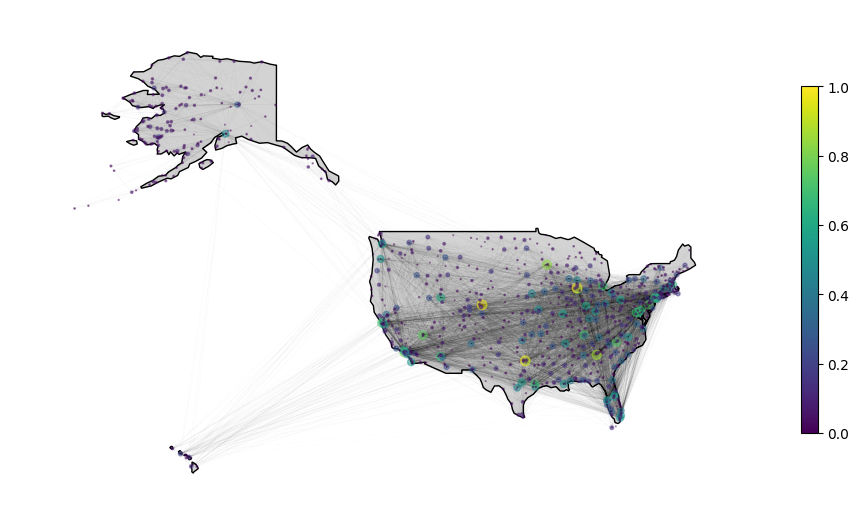

In [36]:
from metrics import get_nodes_out_degree_centrality

# Map projection
fig, ax = plt.subplots(figsize=(12, 9))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter data for the United States
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

# get nodes in degree centrality for the network 

directed_network = nx.DiGraph(spatial_network)
nodes_out_degree_centrality = get_nodes_out_degree_centrality(directed_network)
out_degree_sizes = [nodes_out_degree_centrality[iata] * 50 for iata in spatial_network.nodes]


nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=out_degree_sizes,
                 node_color=out_degree_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis')
                )

# Customize the plot appearance
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
# Show the plot
plt.show()

In [37]:
sorted_nodes_in_degree_centrality = {k: v for k, v in sorted(nodes_in_degree_centrality.items(), key=lambda item: item[1], reverse=True)}
sorted_nodes_out_degree_centrality = {k: v for k, v in sorted(nodes_out_degree_centrality.items(), key=lambda item: item[1], reverse=True)}

in_degree_df = pd.DataFrame.from_dict(sorted_nodes_in_degree_centrality, orient='index', columns=['in_degree_centrality'])
out_degree_df = pd.DataFrame.from_dict(sorted_nodes_out_degree_centrality, orient='index', columns=['out_degree_centrality'])

in_degree_df['iata'] = in_degree_df.index
out_degree_df['iata'] = out_degree_df.index
in_degree_df.reset_index(drop=True, inplace=True)
out_degree_df.reset_index(drop=True, inplace=True)

in_degree_df['name'] = in_degree_df['iata'].apply(lambda x: airports[airports['iata'] == x]['name'].values[0])
out_degree_df['name'] = out_degree_df['iata'].apply(lambda x: airports[airports['iata'] == x]['name'].values[0])

# resort columns 
in_degree_df = in_degree_df[['name', 'iata', 'in_degree_centrality']]
out_degree_df = out_degree_df[['name', 'iata', 'out_degree_centrality']]

In [38]:
in_degree_df.head(10)

name iata  \
0               Chicago O'Hare International Airport  ORD   
1                       Denver International Airport  DEN   
2            Dallas Fort Worth International Airport  DFW   
3   Hartsfield Jackson Atlanta International Airport  ATL   
4  Minneapolis-St Paul International/Wold-Chamber...  MSP   
5            Charlotte Douglas International Airport  CLT   
6                     McCarran International Airport  LAS   
7                                  Teterboro Airport  TEB   
8                  Los Angeles International Airport  LAX   
9               Newark Liberty International Airport  EWR   

   in_degree_centrality  
0              1.000000  
1              0.995169  
2              0.995169  
3              0.913043  
4              0.806763  
5              0.772947  
6              0.772947  
7              0.758454  
8              0.719807  
9              0.710145

In [39]:
out_degree_df.head(10)

name iata  \
0               Chicago O'Hare International Airport  ORD   
1                       Denver International Airport  DEN   
2            Dallas Fort Worth International Airport  DFW   
3   Hartsfield Jackson Atlanta International Airport  ATL   
4  Minneapolis-St Paul International/Wold-Chamber...  MSP   
5                  Los Angeles International Airport  LAX   
6                     McCarran International Airport  LAS   
7                 Philadelphia International Airport  PHL   
8            Charlotte Douglas International Airport  CLT   
9               Newark Liberty International Airport  EWR   

   out_degree_centrality  
0               1.000000  
1               0.973568  
2               0.969163  
3               0.863436  
4               0.832599  
5               0.784141  
6               0.753304  
7               0.748899  
8               0.726872  
9               0.709251

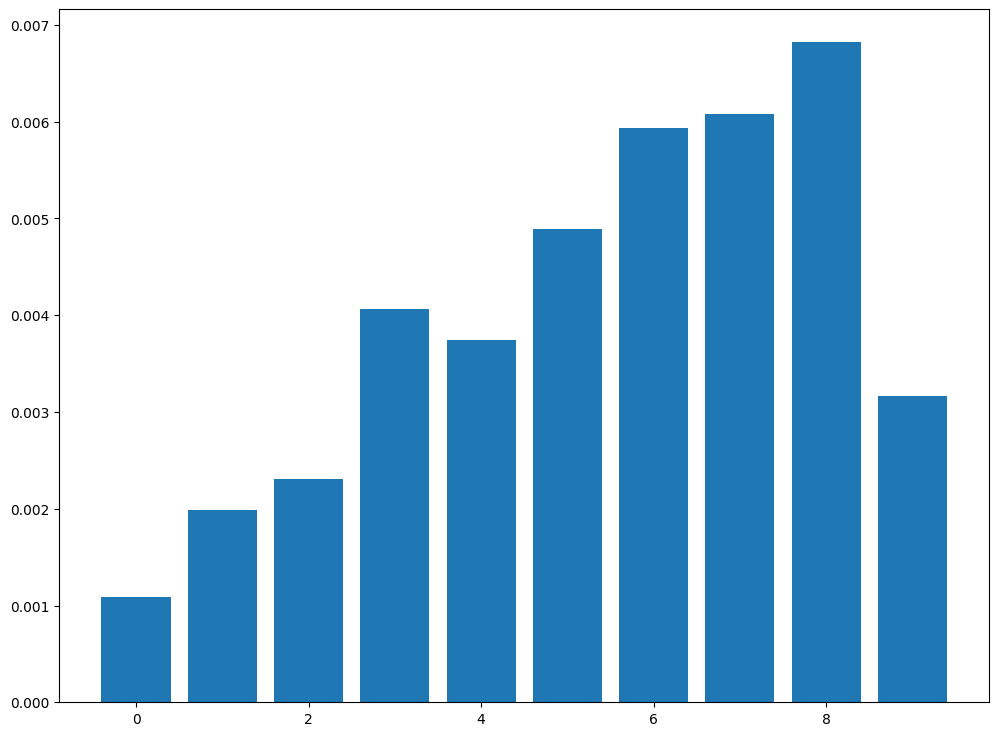

In [40]:
from utils import percentile_graph

in_degree_centrality_percentile = percentile_graph(in_degree_centrality, passengers_per_airport)
# plot the percentile graph
plt.figure(figsize=(12, 9))
plt.bar(np.arange(10), in_degree_centrality_percentile)
plt.show()

### Betweenness Centrality

Betweenness centrality is a measure of a node’s importance
in a network based on the number of shortest paths that pass through it. Hence, nodes with
high betweenness centrality are considered to be structurally important for connecting
regions in the spatial graph. In the temporal graph the betweenness values of the nodes
can be seen as traffic movement. Changes in this metric during different hours of the day
can evaluate traffic movement and predict traffic flow.

Betweenness centrality measures the bridge role a particular
node plays in the network. It calculates a node’s centrality
based on the number of shortest paths for all pairs of vertices
that pass through that node. In simple terms, betweenness
centrality is the sum of the shortest paths that pass through
a node (Song and Yeo 2017). It shows the nodes strength to
act as an intermediary of information fow in the network. 

'ANC' is the airport code of Anchorage airport, a place in Alaska, and according to pagerank and betweenness centrality it is the most important airport in this network. Isn't that weird? Thoughts?

Looks like 'ANC' is essential to the core structure of the network, as it is the main airport connecting Alaska with other parts of US. This explains the high Betweenness Centrality score and there are flights from other major airports to 'ANC' which explains the high PageRank score.



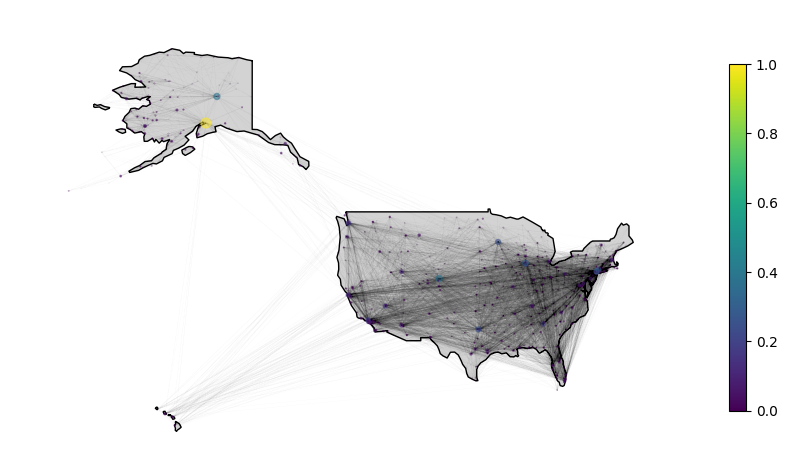

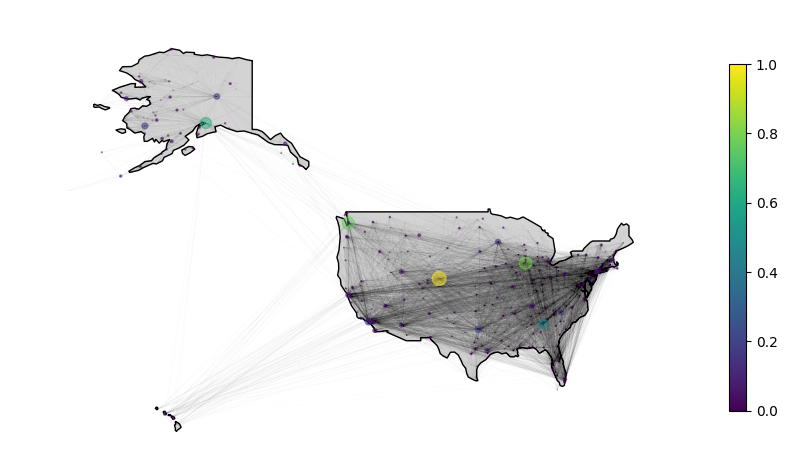

In [41]:
from metrics import get_nodes_betweenness_centrality

# get nodes in degree centrality for the network 

nodes_betweenness_centrality = get_nodes_betweenness_centrality(spatial_network)
betweenness_sizes = [nodes_betweenness_centrality[iata] * 50 for iata in spatial_network.nodes]

fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(1, 2, 1)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=betweenness_sizes,
                 node_color=betweenness_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
# Show the plot
plt.show()


fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(1, 2, 1)

# get nodes in degree centrality for the network 
nodes_betweenness_centrality_weighted = get_nodes_betweenness_centrality(spatial_network, weight='ramp_to_ramp')
betweenness_sizes = [nodes_betweenness_centrality_weighted[iata] * 100 for iata in spatial_network.nodes]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=betweenness_sizes,
                 node_color=betweenness_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
# Show the plot
plt.show()

In [42]:
# sort nodes_betweenness_centrality by value

nodes_betweenness_centrality = dict(sorted(nodes_betweenness_centrality.items(), key=lambda item: item[1], reverse=True))
nodes_betweenness_centrality_weighted = dict(sorted(nodes_betweenness_centrality_weighted.items(), key=lambda item: item[1], reverse=True))

betweenness_df = pd.DataFrame.from_dict(nodes_betweenness_centrality, orient='index', columns=['betweenness_centrality'])
betweenness_df_weighted = pd.DataFrame.from_dict(nodes_betweenness_centrality_weighted, orient='index', columns=['betweenness_centrality_weighted'])

betweenness_df['iata'] = betweenness_df.index
betweenness_df_weighted['iata'] = betweenness_df_weighted.index

betweenness_df.reset_index(drop=True, inplace=True)
betweenness_df_weighted.reset_index(drop=True, inplace=True)

betweenness_df['name'] = betweenness_df['iata'].apply(lambda x: airports[airports['iata'] == x]['name'].values[0])
betweenness_df_weighted['name'] = betweenness_df_weighted['iata'].apply(lambda x: airports[airports['iata'] == x]['name'].values[0])

# resort columns
betweenness_df = betweenness_df[['name', 'iata', 'betweenness_centrality']]
betweenness_df_weighted = betweenness_df_weighted[['name', 'iata', 'betweenness_centrality_weighted']]

In [43]:
betweenness_df.head(10)

name iata  \
0        Ted Stevens Anchorage International Airport  ANC   
1                       Denver International Airport  DEN   
2                    Fairbanks International Airport  FAI   
3               Chicago O'Hare International Airport  ORD   
4                                  Teterboro Airport  TEB   
5            Dallas Fort Worth International Airport  DFW   
6                         Westchester County Airport  HPN   
7  Minneapolis-St Paul International/Wold-Chamber...  MSP   
8               Seattle Tacoma International Airport  SEA   
9   Hartsfield Jackson Atlanta International Airport  ATL   

   betweenness_centrality  
0                1.000000  
1                0.385730  
2                0.383056  
3                0.319692  
4                0.292341  
5                0.261310  
6                0.254898  
7                0.252659  
8                0.199787  
9                0.182035

In [44]:
betweenness_df_weighted.head(10)

name iata  \
0                      Denver International Airport  DEN   
1              Chicago O'Hare International Airport  ORD   
2              Seattle Tacoma International Airport  SEA   
3       Ted Stevens Anchorage International Airport  ANC   
4  Hartsfield Jackson Atlanta International Airport  ATL   
5           Dallas Fort Worth International Airport  DFW   
6                 Los Angeles International Airport  LAX   
7                                    Bethel Airport  BET   
8                   Fairbanks International Airport  FAI   
9           Charlotte Douglas International Airport  CLT   

   betweenness_centrality_weighted  
0                         1.000000  
1                         0.798102  
2                         0.768458  
3                         0.625831  
4                         0.462549  
5                         0.220885  
6                         0.215333  
7                         0.175306  
8                         0.147899  
9                         0.136833

### Closeness Centrality

Closeness centrality measures nodes’ importance in a network
based on how quickly it can reach all other nodes in the network. Regions with high
closeness centrality can quickly access other areas in the network. So in the spatial and
temporal graph the nodes in the center should have the highest closeness centrality scores.


Closeness centrality denotes the node’s reach in a given network. The connection of two nodes is the least number of
hops necessary to reach one node from the other in undirected and unweighted graphs. On the other hand, in networks that are weighted and directed, the distance between
two nodes is afected by direction and magnitude.

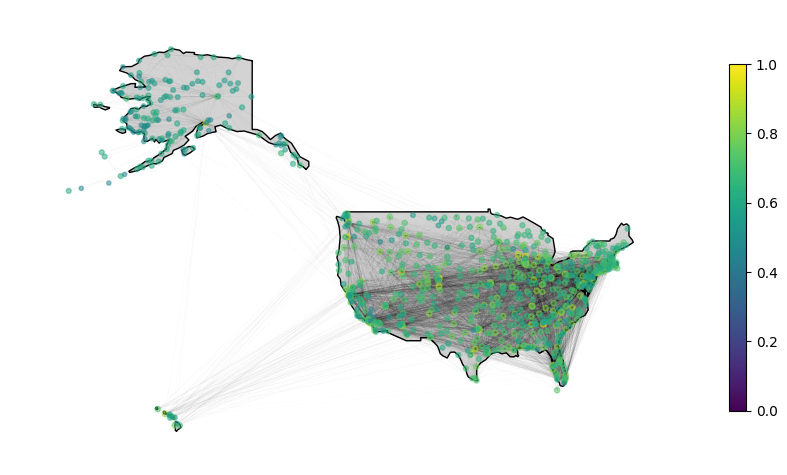

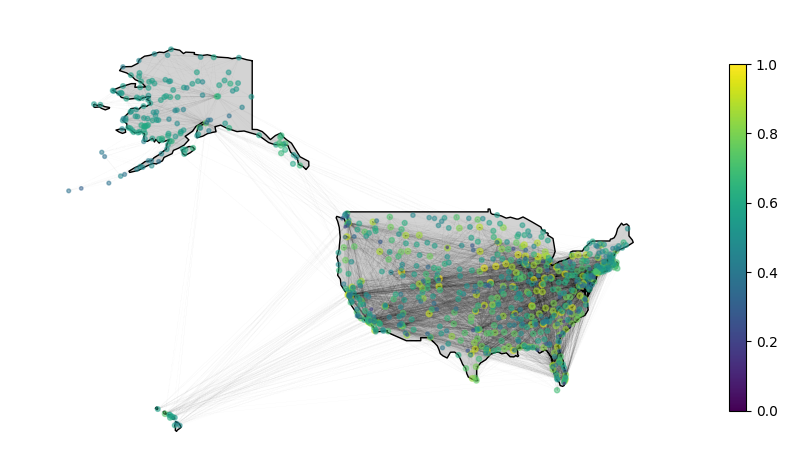

In [48]:
from metrics import get_nodes_closeness_centrality

nodes_closeness_centrality = get_nodes_closeness_centrality(spatial_network)
betweenness_sizes = [nodes_closeness_centrality[iata] * 20 for iata in spatial_network.nodes]

fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(1, 2, 1)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=betweenness_sizes,
                 node_color=betweenness_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
# Show the plot
plt.show()


fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(1, 2, 1)

# get nodes in degree centrality for the network 
nodes_betweenness_centrality_weighted = get_nodes_closeness_centrality(spatial_network, weight='ramp_to_ramp')
betweenness_sizes = [nodes_betweenness_centrality_weighted[iata] * 20 for iata in spatial_network.nodes]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=betweenness_sizes,
                 node_color=betweenness_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
# Show the plot
plt.show()

In [49]:
# sort nodes_closeness_centrality
nodes_closeness_centrality = dict(sorted(nodes_closeness_centrality.items(), key=lambda item: item[1], reverse=True))
closeness_df = pd.DataFrame.from_dict(nodes_closeness_centrality, orient='index', columns=['closeness_centrality'])
closeness_df['iata'] = closeness_df.index
closeness_df.reset_index(drop=True, inplace=True)
closeness_df['name'] = closeness_df['iata'].apply(lambda x: airports[airports['iata'] == x]['name'].values[0])
closeness_df = closeness_df[['name', 'iata', 'closeness_centrality']]

closeness_df.head(10)

name iata  \
0                       Denver International Airport  DEN   
1               Chicago O'Hare International Airport  ORD   
2   Hartsfield Jackson Atlanta International Airport  ATL   
3            Dallas Fort Worth International Airport  DFW   
4  Minneapolis-St Paul International/Wold-Chamber...  MSP   
5                     McCarran International Airport  LAS   
6                  Los Angeles International Airport  LAX   
7                San Francisco International Airport  SFO   
8                                  Teterboro Airport  TEB   
9               Newark Liberty International Airport  EWR   

   closeness_centrality  
0              1.000000  
1              0.998057  
2              0.979034  
3              0.971014  
4              0.966750  
5              0.960125  
6              0.955955  
7              0.955363  
8              0.948308  
9              0.937348

### PageRank centrality


'ANC' is the airport code of Anchorage airport, a place in Alaska, and according to pagerank and betweenness centrality it is the most important airport in this network. Isn't that weird? Thoughts?

Looks like 'ANC' is essential to the core structure of the network, as it is the main airport connecting Alaska with other parts of US. This explains the high Betweenness Centrality score and there are flights from other major airports to 'ANC' which explains the high PageRank score.



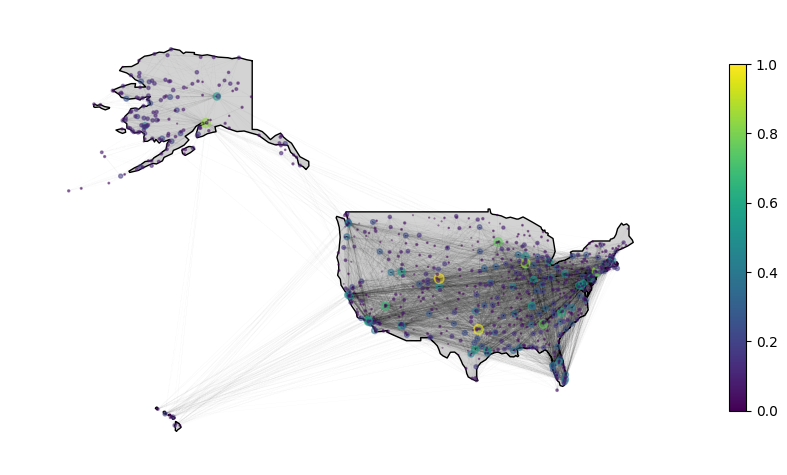

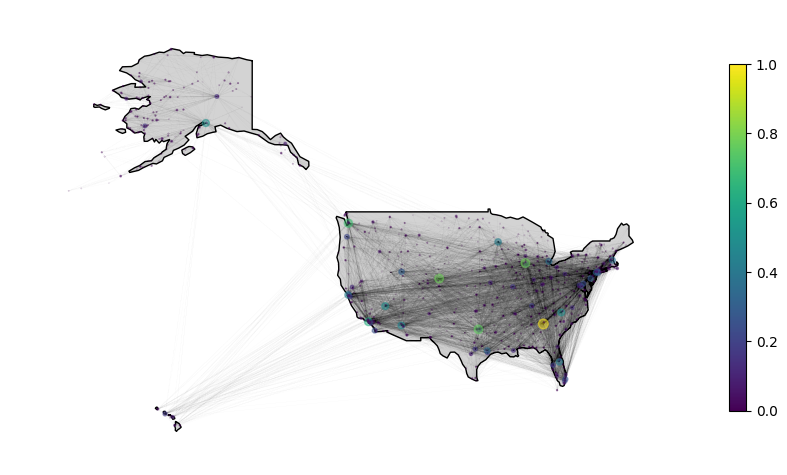

In [50]:
from metrics import get_nodes_pagerank_centrality
# get nodes in degree centrality for the network 
pagerank_centralities = get_nodes_pagerank_centrality(spatial_network)
pagerank_sizes = [pagerank_centralities[iata] * 50 for iata in spatial_network.nodes]

fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(1, 2, 1)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=pagerank_sizes,
                 node_color=pagerank_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
plt.show()

fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(1, 2, 1)

# get nodes in degree centrality for the network 
pagerank_centralities_weighted = get_nodes_pagerank_centrality(spatial_network, weight='passengers')
pagerank_sizes = [pagerank_centralities_weighted[iata] * 50 for iata in spatial_network.nodes]


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=pagerank_sizes,
                 node_color=pagerank_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
plt.show()

In [51]:
# sort nodes_betweenness_centrality by value

pagerank_centralities = dict(sorted(pagerank_centralities.items(), key=lambda item: item[1], reverse=True))
pagerank_centralities_weighted = dict(sorted(pagerank_centralities_weighted.items(), key=lambda item: item[1], reverse=True))

pagerank_df = pd.DataFrame.from_dict(pagerank_centralities, orient='index', columns=['pagerank_centrality'])
pagerank_df_weighted = pd.DataFrame.from_dict(pagerank_centralities_weighted, orient='index', columns=['pagerank_centrality_weighted'])

pagerank_df['iata'] = pagerank_df.index
pagerank_df_weighted['iata'] = pagerank_df_weighted.index

pagerank_df.reset_index(drop=True, inplace=True)
pagerank_df_weighted.reset_index(drop=True, inplace=True)

pagerank_df['name'] = pagerank_df['iata'].apply(lambda x: airports[airports['iata'] == x]['name'].values[0])
pagerank_df_weighted['name'] = pagerank_df_weighted['iata'].apply(lambda x: airports[airports['iata'] == x]['name'].values[0])

pagerank_df = pagerank_df[['name', 'iata', 'pagerank_centrality']]
pagerank_df_weighted = pagerank_df_weighted[['name', 'iata', 'pagerank_centrality_weighted']]

In [52]:
pagerank_df.head(10)

name iata  pagerank_centrality
0                       Denver International Airport  DEN             1.000000
1            Dallas Fort Worth International Airport  DFW             0.994226
2               Chicago O'Hare International Airport  ORD             0.885258
3                                  Teterboro Airport  TEB             0.851891
4        Ted Stevens Anchorage International Airport  ANC             0.843298
5                         Westchester County Airport  HPN             0.821772
6   Hartsfield Jackson Atlanta International Airport  ATL             0.768820
7  Minneapolis-St Paul International/Wold-Chamber...  MSP             0.765399
8                     McCarran International Airport  LAS             0.683329
9                                   Van Nuys Airport  VNY             0.628767

In [53]:
pagerank_df_weighted.head(10)

name iata  \
0  Hartsfield Jackson Atlanta International Airport  ATL   
1              Chicago O'Hare International Airport  ORD   
2                      Denver International Airport  DEN   
3           Dallas Fort Worth International Airport  DFW   
4              Seattle Tacoma International Airport  SEA   
5                 Los Angeles International Airport  LAX   
6       Ted Stevens Anchorage International Airport  ANC   
7           Charlotte Douglas International Airport  CLT   
8                    McCarran International Airport  LAS   
9          Phoenix Sky Harbor International Airport  PHX   

   pagerank_centrality_weighted  
0                      1.000000  
1                      0.779683  
2                      0.778848  
3                      0.755217  
4                      0.692779  
5                      0.623225  
6                      0.503841  
7                      0.490363  
8                      0.486032  
9                      0.466519

### HIST

In the context of an air transport network, nodes could represent airports and edges could represent flight routes between them. The HITS algorithm could be used to identify key airports in the network (hubs) and the influence of different airports based on their connections. For instance, an airport with many connections might be considered a hub, while the influence of an airport could be determined by the number and importance of other airports it is connected to.
The application of the HITS algorithm in the fund trading network, as described in (https://www.semanticscholar.org/paper/The-application-of-Randomized-HITS-algorithm-in-the-Xu-Wang/8b23e9942eab4eba317ef5a767fdd4c857ba5581), provides a good example of how this algorithm can be used to identify key nodes in a network. Similarly, the HITS algorithm could be used to identify key airports in the global air transport network.
However, it's important to note that the specific application of the HITS algorithm would depend on the research questions and objectives of the study. For instance, if the study aims to understand the structure of the global air transport network, the HITS algorithm could be used to identify key airports and flight routes. If the study aims to understand the flow of passengers or cargo through the network, the HITS algorithm could be used to identify key routes and airports in terms of passenger or cargo flow.

In [54]:
from metrics import get_nodes_hits_centrality

# get nodes in degree centrality for the network
hub_scores, auth_scores = get_nodes_hits_centrality(spatial_network, normalize=True)

In [55]:
# sort scores 
hub_scores = dict(sorted(hub_scores.items(), key=lambda item: item[1], reverse=True))
auth_scores = dict(sorted(auth_scores.items(), key=lambda item: item[1], reverse=True))

hub_scores_df = pd.DataFrame(hub_scores.items(), columns=['airport', 'hub_score'])
auth_scores_df = pd.DataFrame(auth_scores.items(), columns=['airport', 'auth_score'])

hub_scores_df['iata'] = hub_scores_df['airport']
auth_scores_df['iata'] = auth_scores_df['airport']

hub_scores_df['name'] = hub_scores_df['iata'].apply(lambda x: airports[airports['iata'] == x]['name'].values[0])
auth_scores_df['name'] = auth_scores_df['iata'].apply(lambda x: airports[airports['iata'] == x]['name'].values[0])

hub_scores_df = hub_scores_df[['name', 'iata', 'hub_score']]
auth_scores_df = auth_scores_df[['name', 'iata', 'auth_score']]

hub_scores_df.head(10)

name iata  hub_score
0               Chicago O'Hare International Airport  ORD   1.000000
1            Dallas Fort Worth International Airport  DFW   0.986081
2   Hartsfield Jackson Atlanta International Airport  ATL   0.982568
3                       Denver International Airport  DEN   0.952947
4  Minneapolis-St Paul International/Wold-Chamber...  MSP   0.921568
5                 Philadelphia International Airport  PHL   0.909328
6               Newark Liberty International Airport  EWR   0.884666
7            Charlotte Douglas International Airport  CLT   0.883782
8          Detroit Metropolitan Wayne County Airport  DTW   0.882481
9       George Bush Intercontinental Houston Airport  IAH   0.881598

In [56]:
auth_scores_df.head(10)

name iata  auth_score
0   Hartsfield Jackson Atlanta International Airport  ATL    1.000000
1               Chicago O'Hare International Airport  ORD    0.989593
2            Dallas Fort Worth International Airport  DFW    0.971749
3                       Denver International Airport  DEN    0.951735
4            Charlotte Douglas International Airport  CLT    0.922050
5               Newark Liberty International Airport  EWR    0.886732
6  Minneapolis-St Paul International/Wold-Chamber...  MSP    0.886239
7            Washington Dulles International Airport  IAD    0.865112
8                 Philadelphia International Airport  PHL    0.856877
9                    Nashville International Airport  BNA    0.847279

### Average Shortest Path

Let's assume you are the Head of Data Science of an airline and your job is to make your airline network as "connected" as possible.

To translate this problem statement to network science, we calculate the average shortest path length of this network, it gives us an idea about the number of jumps we need to make around the network to go from one airport to any other airport in this network on average.

We can use the inbuilt networkx method average_shortest_path_length to find the average shortest path length of a network.

In [124]:
def remove_weakly_connected_components(network):
    components = list(nx.strongly_connected_components(network))
    c = sorted(components, key=len, reverse=True)[0]
    subgraph = spatial_network.subgraph(c)
    return subgraph

In [125]:
subgraph = remove_weakly_connected_components(spatial_network)

In [126]:
print('The average shortest path length of the network is', nx.average_shortest_path_length(subgraph))

The average shortest path length of the network is 2.863689516766221


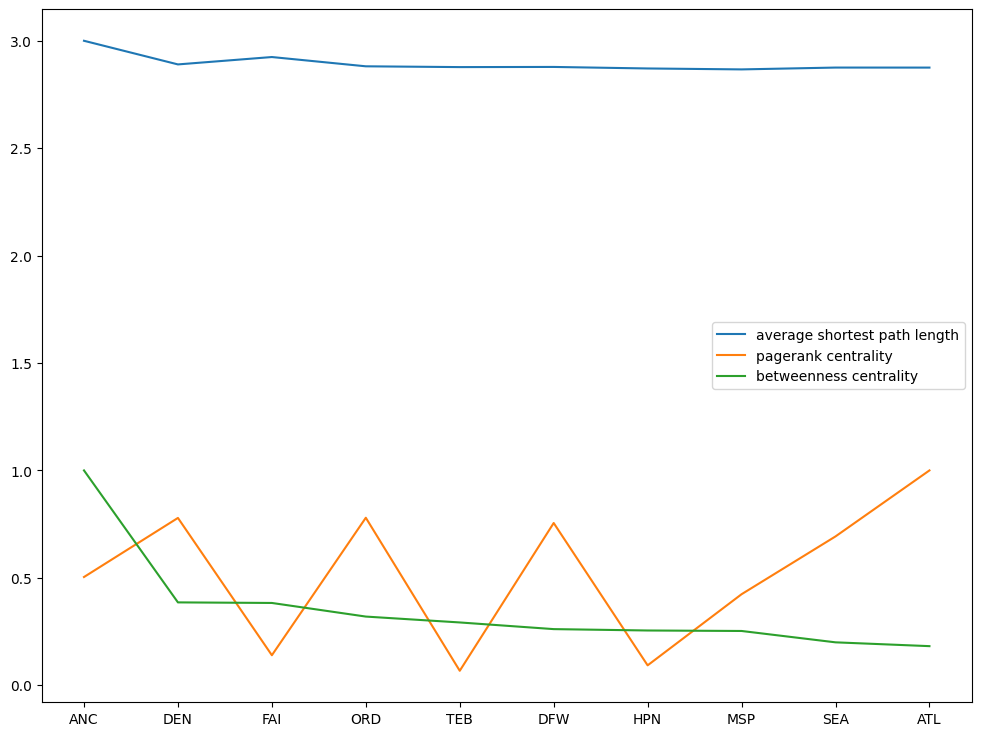

In [99]:
length_without_airport = {}

for iata, _ in nodes_betweenness_centrality_top_10.items():
    directed_network = nx.DiGraph(spatial_network)
    directed_network.remove_node(iata)
    directed_network = remove_weakly_connected_components(directed_network)
    length_without_airport[iata] = {}
    length_without_airport[iata]['avegare_shortest_path'] = nx.average_shortest_path_length(directed_network)
    length_without_airport[iata]['pagerank_centrality'] = pagerank_centralities_weighted[iata]
    length_without_airport[iata]['betweenness_centrality'] = nodes_betweenness_centrality[iata]

# plot for each airport the average shortest path length without it
plt.figure(figsize=(12, 9))
plt.plot(np.arange(10), [length_without_airport[iata]['avegare_shortest_path'] for iata in length_without_airport])
plt.plot(np.arange(10), [length_without_airport[iata]['pagerank_centrality'] for iata in length_without_airport])
plt.plot(np.arange(10), [length_without_airport[iata]['betweenness_centrality'] for iata in length_without_airport])
plt.xticks(np.arange(10), [iata for iata in length_without_airport])
plt.legend(['average shortest path length', 'pagerank centrality', 'betweenness centrality'])
plt.show()

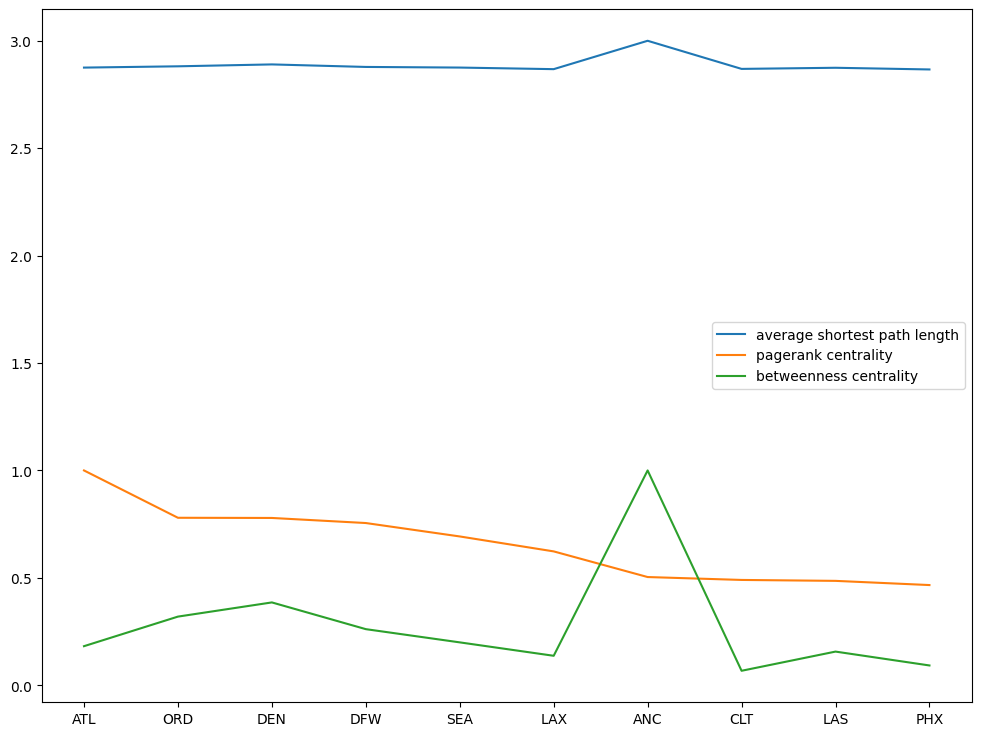

In [100]:
length_without_airport = {}

for iata, _ in pagerank_centralities_weighted_top_10.items():
    directed_network = nx.DiGraph(spatial_network)
    directed_network.remove_node(iata)
    directed_network = remove_weakly_connected_components(directed_network)
    length_without_airport[iata] = {}
    length_without_airport[iata]['avegare_shortest_path'] = nx.average_shortest_path_length(directed_network)
    length_without_airport[iata]['pagerank_centrality'] = pagerank_centralities_weighted[iata]
    length_without_airport[iata]['betweenness_centrality'] = nodes_betweenness_centrality[iata]

# plot for each airport the average shortest path length without it
plt.figure(figsize=(12, 9))
plt.plot(np.arange(10), [length_without_airport[iata]['avegare_shortest_path'] for iata in length_without_airport])
plt.plot(np.arange(10), [length_without_airport[iata]['pagerank_centrality'] for iata in length_without_airport])
plt.plot(np.arange(10), [length_without_airport[iata]['betweenness_centrality'] for iata in length_without_airport])
plt.xticks(np.arange(10), [iata for iata in length_without_airport])
plt.legend(['average shortest path length', 'pagerank centrality', 'betweenness centrality'])
plt.show()

## Disruption Analysis

In [57]:
# get the most important airports, sum of in degree centrality and out degree centrality df 
most_important_airports = pd.merge(in_degree_df, out_degree_df, on=['iata'])
most_important_airports = most_important_airports[['iata', 'in_degree_centrality', 'out_degree_centrality']]
most_important_airports = pd.merge(most_important_airports, betweenness_df_weighted, on=['iata'])
most_important_airports = most_important_airports[['iata', 'in_degree_centrality', 'out_degree_centrality', 'betweenness_centrality_weighted']]
most_important_airports = pd.merge(most_important_airports, closeness_df, on=['iata'])
most_important_airports = most_important_airports[['iata', 'in_degree_centrality', 'out_degree_centrality', 'betweenness_centrality_weighted', 'closeness_centrality']]
most_important_airports = pd.merge(most_important_airports, pagerank_df_weighted, on=['iata'])
most_important_airports = most_important_airports[['iata', 'in_degree_centrality', 'out_degree_centrality', 'betweenness_centrality_weighted', 'closeness_centrality', 'pagerank_centrality_weighted']]
most_important_airports = pd.merge(most_important_airports, hub_scores_df, on=['iata'])
most_important_airports = most_important_airports[['iata', 'in_degree_centrality', 'out_degree_centrality', 'betweenness_centrality_weighted', 'closeness_centrality', 'pagerank_centrality_weighted', 'hub_score']]
most_important_airports = pd.merge(most_important_airports, auth_scores_df, on=['iata'])
most_important_airports = most_important_airports[['iata', 'in_degree_centrality', 'out_degree_centrality', 'betweenness_centrality_weighted', 'closeness_centrality', 'pagerank_centrality_weighted', 'hub_score', 'auth_score']]
most_important_airports['sum_degree_centrality'] = 0.5 * most_important_airports['in_degree_centrality'] + 0.5 * most_important_airports['out_degree_centrality'] + most_important_airports['betweenness_centrality_weighted'] + most_important_airports['closeness_centrality'] + most_important_airports['pagerank_centrality_weighted'] + most_important_airports['hub_score'] + most_important_airports['auth_score']
most_important_airports.sort_values('sum_degree_centrality', ascending=False, inplace=True)
most_important_airports.reset_index(drop=True, inplace=True)
most_important_airports.head(10)

iata  in_degree_centrality  out_degree_centrality  \
0  DEN              0.995169               0.973568   
1  ORD              1.000000               1.000000   
2  ATL              0.913043               0.863436   
3  DFW              0.995169               0.969163   
4  SEA              0.526570               0.585903   
5  LAX              0.719807               0.784141   
6  MSP              0.806763               0.832599   
7  CLT              0.772947               0.726872   
8  LAS              0.772947               0.753304   
9  EWR              0.710145               0.709251   

   betweenness_centrality_weighted  closeness_centrality  \
0                         1.000000              1.000000   
1                         0.798102              0.998057   
2                         0.462549              0.979034   
3                         0.220885              0.971014   
4                         0.768458              0.926639   
5                         0.215333              0.955955   
6                         0.133094              0.966750   
7                         0.136833              0.888697   
8                         0.044211              0.960125   
9                         0.064305              0.937348   

   pagerank_centrality_weighted  hub_score  auth_score  sum_degree_centrality  
0                      0.778848   0.952947    0.951735               5.667899  
1                      0.779683   1.000000    0.989593               5.565435  
2                      1.000000   0.982568    1.000000               5.312391  
3                      0.755217   0.986081    0.971749               4.887113  
4                      0.692779   0.718996    0.643371               4.306480  
5                      0.623225   0.863652    0.814197               4.224335  
6                      0.423757   0.921568    0.886239               4.151089  
7                      0.490363   0.883782    0.922050               4.071635  
8                      0.486032   0.867450    0.843058               3.964002  
9                      0.316395   0.884666    0.886732               3.799144

In [58]:
most_important_airports['mean_score'] = most_important_airports['sum_degree_centrality'] / 7
most_important_airports[['iata', 'mean_score']].head(10)

iata  mean_score
0  DEN    0.809700
1  ORD    0.795062
2  ATL    0.758913
3  DFW    0.698159
4  SEA    0.615211
5  LAX    0.603476
6  MSP    0.593013
7  CLT    0.581662
8  LAS    0.566286
9  EWR    0.542735

In [59]:
print(f'Number of nodes in the spatial network: {len(spatial_network.nodes())}')
print(f'Number of edges in the spatial network: {len(spatial_network.edges())}')
print(f'Spatial network density: {nx.density(spatial_network)}')

Number of nodes in the spatial network: 844
Number of edges in the spatial network: 18487
Spatial network density: 0.025983426377246686


In [60]:
from utils import remove_weakly_connected_components, remove_airport

In [61]:
nx.number_connected_components(spatial_network.to_undirected())

3

In [62]:
subgraph = remove_weakly_connected_components(spatial_network)

print(f'Number of nodes in the spatial network: {len(subgraph.nodes())}')
print(f'Number of edges in the spatial network: {len(subgraph.edges())}')
print(f'Spatial network density: {nx.density(subgraph)}')

print('The average shortest path length of the network is', nx.average_shortest_path_length(subgraph, weight='ramp_to_ramp'))
print('The                                                                                                                                                                                  diameter of the network is', nx.diameter(subgraph))
print('The number of connected components in the network is', nx.number_connected_components(subgraph.to_undirected()))

Number of nodes in the spatial network: 796
Number of edges in the spatial network: 18427
Spatial network density: 0.029118864764071932
The average shortest path length of the network is 144.55166818420045
The diameter of the network is 7
The number of connected components in the network is 1


In [63]:
top10_most_important_airports = list(most_important_airports['iata'].head(10).values)

In [64]:
top10_most_important_airports

['DEN', 'ORD', 'ATL', 'DFW', 'SEA', 'LAX', 'MSP', 'CLT', 'LAS', 'EWR']

In [65]:
most_important_airports = ['ANC', 'ATL', 'ORD', 'DFW', 'DEN']

In [66]:
betweenness_before = get_nodes_betweenness_centrality(spatial_network, weight='ramp_to_ramp')
pagerank_before = get_nodes_pagerank_centrality(spatial_network, weight='passengers')

In [71]:
nodes = []
edges = []
densities = []

for airport in top10_most_important_airports:
    subgraph = nx.DiGraph(spatial_network)
    subgraph.remove_node(airport)
    # subgraph = remove_weakly_connected_components(subgraph)
    nodes_num = len(subgraph.nodes())
    edges_num = len(subgraph.edges())
    density = nx.density(subgraph)
    nodes.append(nodes_num)
    edges.append(edges_num)
    densities.append(density)

df = pd.DataFrame({'Removed Airport': top10_most_important_airports, '# of nodes': nodes, '# of edges': edges, 'density': densities})
df

Removed Airport  # of nodes  # of edges   density
0             DEN         843       18060  0.025444
1             ORD         843       18053  0.025434
2             ATL         843       18102  0.025503
3             DFW         843       18061  0.025445
4             SEA         843       18245  0.025704
5             LAX         843       18160  0.025584
6             MSP         843       18131  0.025544
7             CLT         843       18162  0.025587
8             LAS         843       18156  0.025579
9             EWR         843       18179  0.025611

In [182]:
avg_short_path_list = []
diameter_list = []
num_connected_comps_list = []
max_betweenness_list = []
node_betweenness_list = []
max_pagerank_list = []
node_pagerank_list = []

for airport in top10_most_important_airports:
    print('removing airport:', airport)
    avg_short_path, diameter, num_connected_comps, max_betweenness, node_betweenness, max_pagerank, node_pagerank = remove_airport(spatial_network, airport, betweenness_before, pagerank_before)
    avg_short_path_list.append(avg_short_path)
    diameter_list.append(diameter)
    num_connected_comps_list.append(num_connected_comps)
    max_betweenness_list.append(max_betweenness)
    node_betweenness_list.append(node_betweenness)
    max_pagerank_list.append(max_pagerank)
    node_pagerank_list.append(node_pagerank)

removing airport: DEN
removing airport: ORD
removing airport: ATL
removing airport: DFW
removing airport: SEA
removing airport: LAX
removing airport: MSP
removing airport: CLT
removing airport: LAS
removing airport: EWR


In [95]:
connected_comps = nx.connected_components(spatial_network.to_undirected())

In [96]:
original_comps = [comp for comp in connected_comps]

In [98]:
for airport in top10_most_important_airports:
    print(airport)
    new_network = nx.DiGraph(spatial_network)
    new_network.remove_node(airport)
    connected_comps = nx.connected_components(new_network.to_undirected())
    comps = [comp for comp in connected_comps]
    for comp in comps:
        if comp not in original_comps:
            print(comp)

DEN
{'BPT', 'EWB', 'DUT', 'GUC', 'AUG', 'ABY', 'ISO', 'LAS', 'FNL', 'BMG', 'ANV', 'RST', 'AST', 'ARA', 'ISM', 'LWM', 'STP', 'SMK', 'ALW', 'ISP', 'BTR', 'MFR', 'WSN', 'DLH', 'ITH', 'BID', 'DRT', 'AUK', 'PIZ', 'ADS', 'VEE', 'FOE', 'JXN', 'TKJ', 'BKW', 'HGR', 'LAX', 'NHZ', 'SUN', 'MDH', 'GJT', 'OBE', 'IND', 'SBY', 'BLI', 'SRQ', 'TBN', 'TMB', 'MHE', 'BBX', 'SOW', 'BFD', 'PIR', 'GCK', 'LNK', 'SXQ', 'CGF', 'VAD', 'KMO', 'TUP', 'SAC', 'UIN', 'PAH', 'PUW', 'EGX', 'FAY', 'FWA', 'DMA', 'FRD', 'RBD', 'CIC', 'SMO', 'BGR', 'MVY', 'KNW', 'TTN', 'ATY', 'SQL', 'ADW', 'MCN', 'SKF', 'FCA', 'SAD', 'JRA', 'ANP', 'BFM', 'ARC', 'PUB', 'SCC', 'OKC', 'BFT', 'KTS', 'CNY', 'MLY', 'LNY', 'SUU', 'VGT', 'CMX', 'SUA', 'APC', 'CLU', 'CXL', 'HPB', 'LBL', 'CON', 'FST', 'BHB', 'MMH', 'PIB', 'NUI', 'SGY', 'BUF', 'KUK', 'GEG', 'APA', 'AGN', 'DFW', 'RIV', 'BKG', 'KGK', 'LMT', 'LWB', 'MHV', 'ALO', 'MBL', 'TEX', 'SMN', 'ESN', 'GCC', 'OGG', 'OCF', 'DRG', 'MCE', 'WRG', 'SLK', 'UOX', 'KPV', 'EEK', 'PSM', 'MLU', 'ACK', 'ENV', '

In [93]:
comps

[{'ABE',
  'ABI',
  'ABL',
  'ABQ',
  'ABR',
  'ABY',
  'ACK',
  'ACT',
  'ACV',
  'ACY',
  'ADK',
  'ADQ',
  'ADS',
  'ADW',
  'AET',
  'AEX',
  'AFW',
  'AGC',
  'AGN',
  'AGS',
  'AHN',
  'AIA',
  'AIK',
  'AIN',
  'AIZ',
  'AKB',
  'AKI',
  'AKK',
  'AKN',
  'AKP',
  'ALB',
  'ALO',
  'ALS',
  'ALW',
  'AMA',
  'ANB',
  'ANC',
  'AND',
  'ANI',
  'ANP',
  'ANV',
  'AOO',
  'APA',
  'APC',
  'APF',
  'APN',
  'ARA',
  'ARC',
  'ART',
  'ASE',
  'ASH',
  'ASN',
  'AST',
  'ATK',
  'ATW',
  'ATY',
  'AUG',
  'AUK',
  'AUS',
  'AVL',
  'AVP',
  'AVW',
  'AZA',
  'AZO',
  'BAF',
  'BBX',
  'BCE',
  'BCT',
  'BDL',
  'BDR',
  'BED',
  'BET',
  'BFD',
  'BFF',
  'BFI',
  'BFK',
  'BFL',
  'BFM',
  'BFT',
  'BGD',
  'BGM',
  'BGR',
  'BHB',
  'BHM',
  'BID',
  'BIF',
  'BIH',
  'BIL',
  'BIS',
  'BJC',
  'BJI',
  'BKC',
  'BKG',
  'BKL',
  'BKW',
  'BLF',
  'BLI',
  'BLV',
  'BMG',
  'BMI',
  'BNA',
  'BOI',
  'BOS',
  'BPT',
  'BQK',
  'BRD',
  'BRL',
  'BRO',
  'BRW',
  'BTI',
  'BTM',
 

In [189]:
disruption_df = pd.DataFrame({'airport': top10_most_important_airports, 'avg_short_path': avg_short_path_list, 'num_connected_comps': num_connected_comps_list, 'max_betweenness': max_betweenness_list, 'node_betweenness': node_betweenness_list, 'max_pagerank': max_pagerank_list, 'node_pagerank': node_pagerank_list})
disruption_df['before_avg_short_path'] = 144.55
disruption_df['before_num_connected_comps'] = 3
# disruption_df['diameter_ratio'] = disruption_df['diameter'] / disruption_df['before_diameter'] * 100 - 100
# disruption_df['avg_short_path_ratio'] = disruption_df['avg_short_path'] / disruption_df['before_avg_short_path'] * 100 - 100
# disruption_df['num_connected_comps_ratio'] = disruption_df['num_connected_comps'] / disruption_df['before_num_connected_comps'] * 100 - 100
# sort disruption_df columns
disruption_df['name_airport'] = disruption_df['airport'].apply(lambda x: airports[airports['iata'] == x]['name'].values[0])
disruption_df = disruption_df[['name_airport', 'airport', 'before_avg_short_path', 'avg_short_path', 'before_num_connected_comps', 'num_connected_comps', 'max_betweenness', 'node_betweenness', 'max_pagerank', 'node_pagerank']]
# approximated values to 4 decimals
disruption_df = disruption_df.round(4)
disruption_df

name_airport airport  \
0                       Denver International Airport     DEN   
1               Chicago O'Hare International Airport     ORD   
2   Hartsfield Jackson Atlanta International Airport     ATL   
3            Dallas Fort Worth International Airport     DFW   
4               Seattle Tacoma International Airport     SEA   
5                  Los Angeles International Airport     LAX   
6  Minneapolis-St Paul International/Wold-Chamber...     MSP   
7            Charlotte Douglas International Airport     CLT   
8                     McCarran International Airport     LAS   
9               Newark Liberty International Airport     EWR   

   before_avg_short_path  avg_short_path  before_num_connected_comps  \
0                 144.55        181.8935                           3   
1                 144.55        147.5505                           3   
2                 144.55        146.4270                           3   
3                 144.55        146.9287                           3   
4                 144.55        155.5912                           3   
5                 144.55        145.2560                           3   
6                 144.55        144.9947                           3   
7                 144.55        145.3566                           3   
8                 144.55        145.3014                           3   
9                 144.55        144.8669                           3   

   num_connected_comps  max_betweenness node_betweenness  max_pagerank  \
0                    4           0.2019              ORD        0.0008   
1                    4           0.1380              ATL        0.0002   
2                    5           0.1645              ORD        0.0002   
3                    4           0.0397              IAH        0.0002   
4                    3           0.6082              PDX        0.0002   
5                    4           0.0646              SFO        0.0002   
6                    3           0.0226              DTW        0.0012   
7                    3           0.0167              ATL        0.0002   
8                    3           0.0117              PHX        0.0002   
9                    3           0.0220              LGA        0.0002   

  node_pagerank  
0           AIA  
1           ARA  
2           OCF  
3           MWL  
4           ARA  
5           ARA  
6           FCM  
7           ARA  
8           ARA  
9           ARA

## Temporal Network

In [ ]:
def get_month_network(network, month):
    """ 
    Extract edges for a particular year from
    a MultiGraph. The edge is also populated with
    two attributes, weight and weight_inv where
    weight is the number of passengers and
    weight_inv the inverse of it.
    """
    month_network = nx.DiGraph()
    for edge in network.edges:
        source, target, edge_month = edge
        if edge_month == month:
            attr = network[source][target][edge_month]
            passengers = attr['passengers']
            departures_performed = attr['departures_performed']
            month_network.add_edge(
                source, target,
                passengers=passengers,
                passengers_log=np.log(passengers),
                passengers_inv=1/(passengers if passengers != 0.0 else 1),
                departures_performed=departures_performed,
                departures_performed_log=np.log(departures_performed),
                )
    return month_network

In [48]:
months_networks = {}

for month in range(1, 13):
    months_networks[month] = get_month_network(passenger_graph, month)

In [60]:
months_networks[month].edges

OutEdgeView([('ABE', 'ATL'), ('ABE', 'CLT'), ('ABE', 'DCA'), ('ABE', 'DTW'), ('ABE', 'FLL'), ('ABE', 'LAS'), ('ABE', 'ORD'), ('ABE', 'PGD'), ('ABE', 'PHL'), ('ABE', 'PIE'), ('ABE', 'SFB'), ('ATL', 'ABE'), ('ATL', 'ABQ'), ('ATL', 'ABY'), ('ATL', 'AEX'), ('ATL', 'AGS'), ('ATL', 'ALB'), ('ATL', 'ASE'), ('ATL', 'ATW'), ('ATL', 'AUS'), ('ATL', 'AVL'), ('ATL', 'AVP'), ('ATL', 'BDL'), ('ATL', 'BED'), ('ATL', 'BHM'), ('ATL', 'BMI'), ('ATL', 'BNA'), ('ATL', 'BOS'), ('ATL', 'BQK'), ('ATL', 'BTR'), ('ATL', 'BTV'), ('ATL', 'BUF'), ('ATL', 'BUR'), ('ATL', 'BWI'), ('ATL', 'BZN'), ('ATL', 'CAE'), ('ATL', 'CAK'), ('ATL', 'CHA'), ('ATL', 'CHO'), ('ATL', 'CHS'), ('ATL', 'CID'), ('ATL', 'CLE'), ('ATL', 'CLT'), ('ATL', 'CMH'), ('ATL', 'COS'), ('ATL', 'CRW'), ('ATL', 'CSG'), ('ATL', 'CVG'), ('ATL', 'DAB'), ('ATL', 'DAL'), ('ATL', 'DAY'), ('ATL', 'DCA'), ('ATL', 'DEN'), ('ATL', 'DFW'), ('ATL', 'DHN'), ('ATL', 'DSM'), ('ATL', 'DTW'), ('ATL', 'ECP'), ('ATL', 'EGE'), ('ATL', 'ELM'), ('ATL', 'ELP'), ('ATL', 'EV

In [82]:
total_passengers = []
total_edges = []
total_nodes = []

for month in range(1, 13):
    passengers = 0
    edges_num = 0
    nodes_num = 0
    for origin, dest in months_networks[month].edges:
        passengers += months_networks[month][origin][dest]['passengers']
        edges_num += 1
    for node in months_networks[month].nodes:
        nodes_num += 1
    total_passengers.append(passengers)
    total_edges.append(edges_num)
    total_nodes.append(nodes_num)

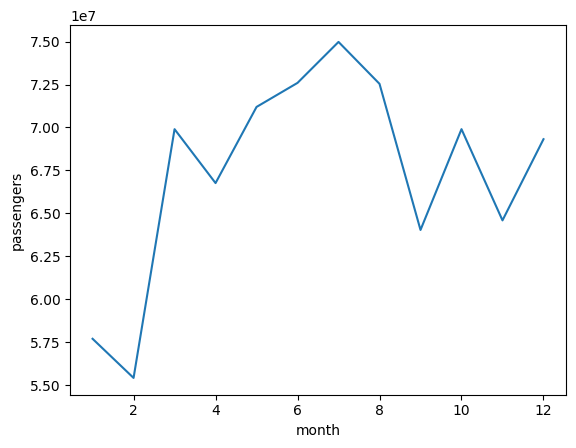

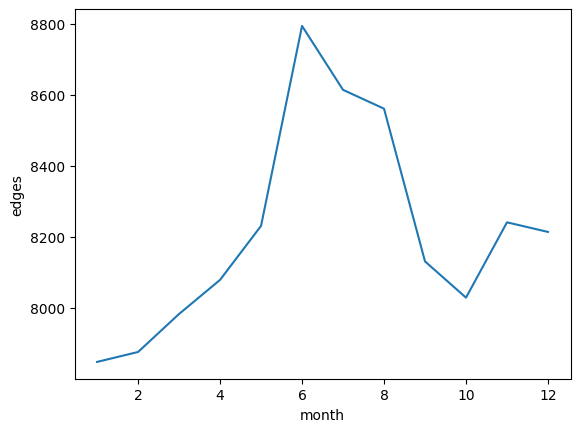

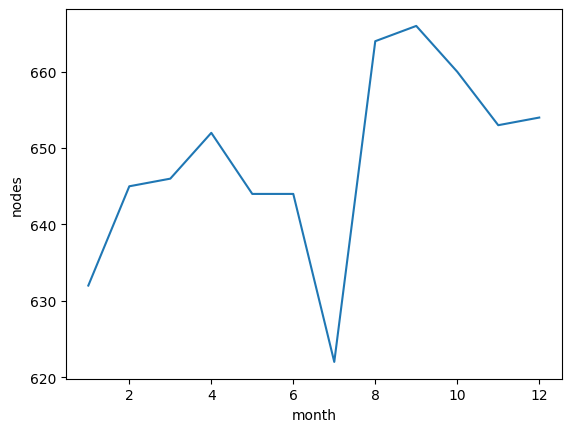

In [83]:
plt.plot(np.arange(1, 13), total_passengers)
plt.xlabel('month')
plt.ylabel('passengers')
plt.show()

plt.plot(np.arange(1, 13), total_edges)
plt.xlabel('month')
plt.ylabel('edges')
plt.show()

plt.plot(np.arange(1, 13), total_nodes)
plt.xlabel('month')
plt.ylabel('nodes')
plt.show()

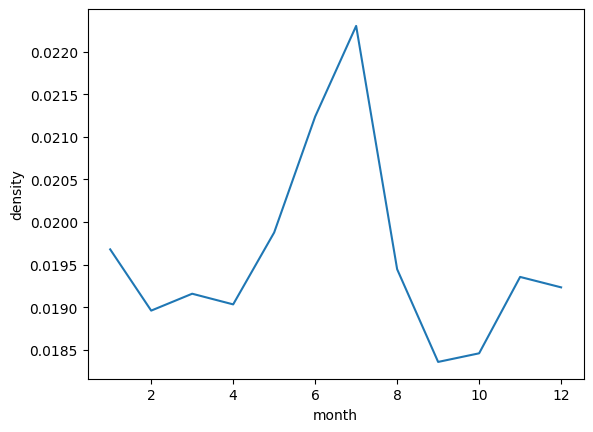

In [50]:
densities = [nx.density(months_networks[month]) for month in months_networks]

plt.plot(np.arange(1, 13), densities)
plt.xlabel('month')
plt.ylabel('density')
plt.show()

To test different situations of an airline network in the US, you could consider the following four months, each offering unique conditions:

1. **January**: This month is typically characterized by high passenger demand due to the holiday season. Airlines often experience a surge in travelers during the Christmas and New Year holidays, with some airlines expecting record-breaking traffic[5][8][11]. 

2. **April**: This month can be considered a relatively low season for airlines. After the busy holiday and spring break periods, April often sees a decrease in passenger demand. This would provide a contrasting situation to the high-demand scenario in January.

3. **July**: This month is part of the summer season, which is another peak travel period in the US. Many people take vacations during this time, leading to increased passenger demand. According to the Bureau of Transportation Statistics, airlines often see a rise in passenger numbers during this month[3].

4. **September**: This month may experience a decrease in leisure travelers, but business travel might still be present. Additionally, September is often considered a shoulder season, with fewer crowds and more affordable flight (https://www.npr.org/2023/12/23/1221427263/busiest-holiday-travel-season-in-years-is-off-to-a-smooth-start) This mix of travel patterns makes September a suitable choice for testing different situations of an airline network in the US.

These months should provide a variety of situations for testing, including high-demand holiday seasons, a typical low season, and the busy summer travel period.

Citations:
[1] https://www.transtats.bts.gov/traffic/
[2] https://www.travelweekly.com/Travel-News/Airline-News/how-did-airlines-fare-over-holidays
[3] https://www.bts.gov/newsroom/monthly-passengers-us-scheduled-airlines-domestic-international-seasonally-adjusted
[4] https://www.bts.gov/newsroom/full-year-2022-us-airline-traffic-data
[5] https://www.travelandleisure.com/delta-united-american-holiday-air-travel-flights-christmas-new-years-8415901
[6] https://www.faa.gov/air_traffic/by_the_numbers
[7] https://www.transportation.gov/policy/aviation-policy/us-international-air-passenger-and-freight-statistics-report
[8] https://www.foxbusiness.com/lifestyle/major-us-airlines-expect-surge-holiday-travelers
[9] https://www.oag.com/frequency-capacity-statistics
[10] https://www.airlines.org/dataset/state-of-us-aviation/
[11] https://www.cnn.com/travel/christmas-holidays-airline-traffic-increase-2023/index.html
[12] https://www.airlines.org/dataset/air-travelers-in-america-annual-survey/
[13] https://www.trade.gov/us-international-air-travel-statistics-i-92-data
[14] https://www.npr.org/2023/12/23/1221427263/busiest-holiday-travel-season-in-years-is-off-to-a-smooth-start
[15] https://www.usatoday.com/story/travel/airline-news/2023/03/16/airline-time-performance-data-2022/11486644002/
[16] https://www.statista.com/statistics/193533/growth-of-global-air-traffic-passenger-demand/
[17] https://www.reuters.com/business/aerospace-defense/airlines-predict-record-thanksgiving-us-holiday-travel-2023-11-13/
[18] https://www.oag.com
[19] https://www.iata.org/en/services/statistics/industry-insights--market-data/20-year-passenger-forecast/
[20] https://www.prnewswire.com/news-releases/us-airlines-prepared-to-meet-demand-this-winter-holiday-season-302016081.html
[21] https://www.statista.com/topics/5575/passenger-airlines-in-the-us/
[22] https://news.aa.com/news/news-details/2024/American-Airlines-produces-industry-leading-performance-during-the-winter-holiday-travel-period-OPS-OTH-01/

### PageRank analysis

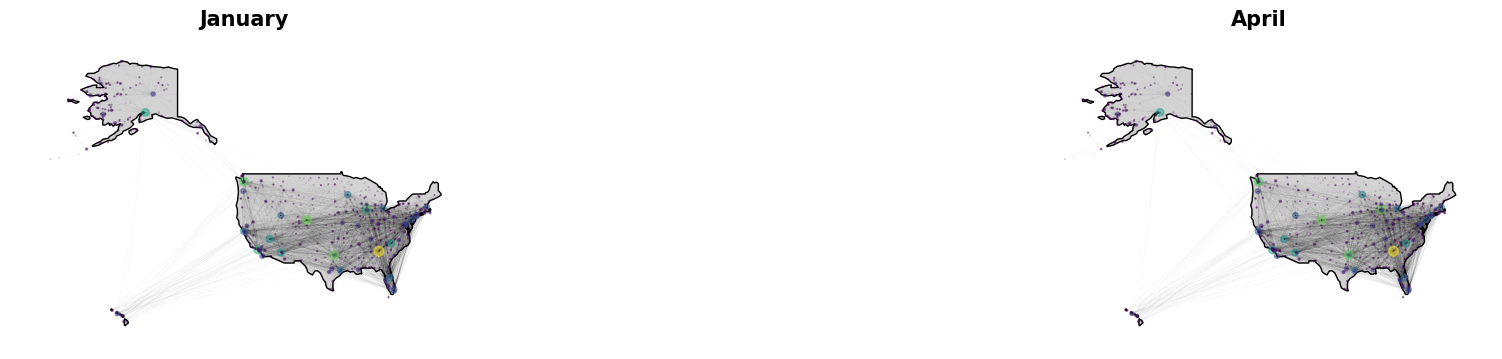

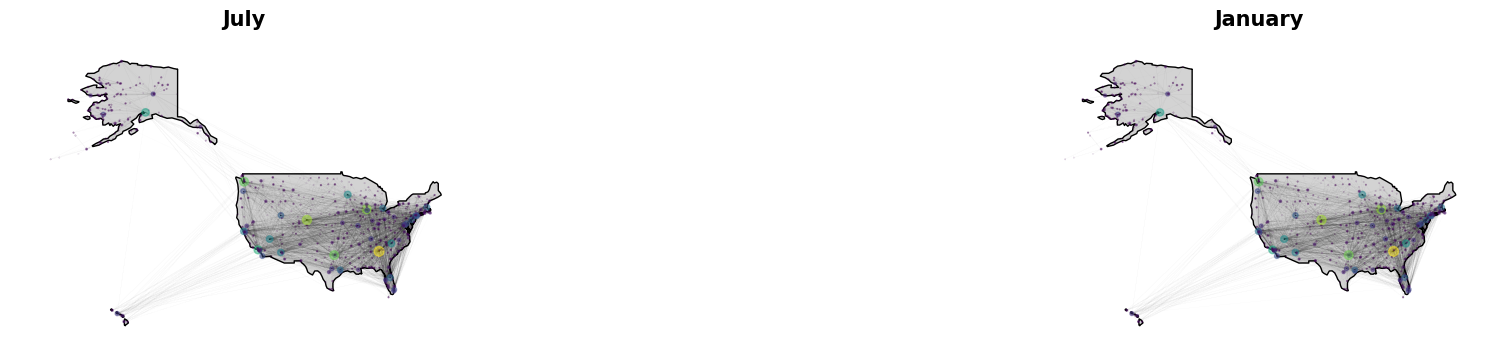

In [105]:
from metrics import get_nodes_pagerank_centrality
fig = plt.figure(figsize=(24, 9))

# JANUARY 

month = 1

pagerank_centralities = get_nodes_pagerank_centrality(months_networks[month], weight='passengers')
pagerank_sizes = [pagerank_centralities[iata] * 50 for iata in months_networks[month].nodes]

ax = fig.add_subplot(2, 2, 1)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

nx.draw_networkx(months_networks[month], 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=pagerank_sizes,
                 node_color=pagerank_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('January', fontsize=15, fontweight='bold')

ax = fig.add_subplot(2, 2, 2)

# APRIL 

month = 4

pagerank_centralities = get_nodes_pagerank_centrality(months_networks[month], weight='passengers')
pagerank_sizes = [pagerank_centralities[iata] * 50 for iata in months_networks[month].nodes]


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(months_networks[month], 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=pagerank_sizes,
                 node_color=pagerank_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('April', fontsize=15, fontweight='bold')

# JULY 

month = 7

pagerank_centralities = get_nodes_pagerank_centrality(months_networks[month], weight='passengers')
pagerank_sizes = [pagerank_centralities[iata] * 50 for iata in months_networks[month].nodes]

fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(2, 2, 3)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(months_networks[month], 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=pagerank_sizes,
                 node_color=pagerank_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('July', fontsize=15, fontweight='bold')

# SEPTEMBER 

ax = fig.add_subplot(2, 2, 4)

month = 9

pagerank_centralities = get_nodes_pagerank_centrality(months_networks[month], weight='passengers')
pagerank_sizes = [pagerank_centralities[iata] * 50 for iata in months_networks[month].nodes]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

nx.draw_networkx(months_networks[month], 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=pagerank_sizes,
                 node_color=pagerank_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('September', fontsize=15, fontweight='bold')

# Show the plot
plt.show()

### Betweenness Analysis

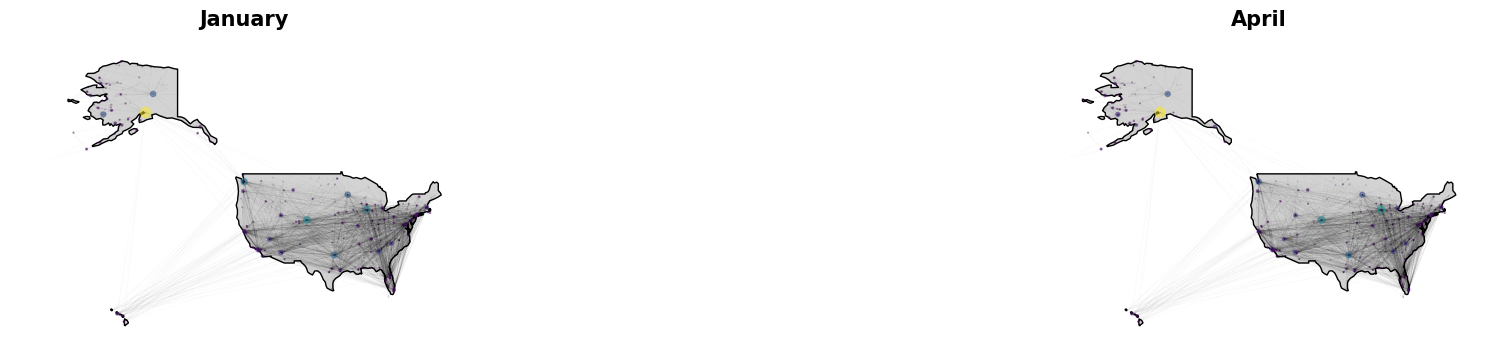

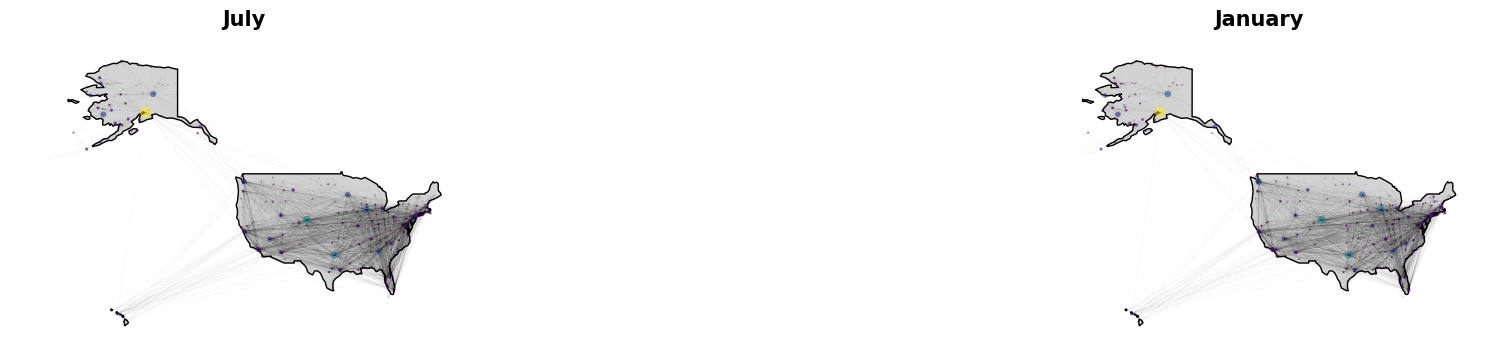

In [106]:
from metrics import get_nodes_betweenness_centrality
fig = plt.figure(figsize=(24, 9))

# JANUARY 

month = 1

pagerank_centralities = get_nodes_betweenness_centrality(months_networks[month]) #, weight='passengers_inv')
pagerank_sizes = [pagerank_centralities[iata] * 50 for iata in months_networks[month].nodes]

ax = fig.add_subplot(2, 2, 1)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

nx.draw_networkx(months_networks[month], 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=pagerank_sizes,
                 node_color=pagerank_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('January', fontsize=15, fontweight='bold')

ax = fig.add_subplot(2, 2, 2)

# APRIL 

month = 4

pagerank_centralities = get_nodes_betweenness_centrality(months_networks[month])
pagerank_sizes = [pagerank_centralities[iata] * 50 for iata in months_networks[month].nodes]


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(months_networks[month], 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=pagerank_sizes,
                 node_color=pagerank_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('April', fontsize=15, fontweight='bold')

# JULY 

month = 7

pagerank_centralities = get_nodes_betweenness_centrality(months_networks[month])
pagerank_sizes = [pagerank_centralities[iata] * 50 for iata in months_networks[month].nodes]

fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(2, 2, 3)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(months_networks[month], 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=pagerank_sizes,
                 node_color=pagerank_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('July', fontsize=15, fontweight='bold')

# SEPTEMBER 

ax = fig.add_subplot(2, 2, 4)

month = 9

pagerank_centralities = get_nodes_betweenness_centrality(months_networks[month])
pagerank_sizes = [pagerank_centralities[iata] * 50 for iata in months_networks[month].nodes]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

nx.draw_networkx(months_networks[month], 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=pagerank_sizes,
                 node_color=pagerank_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('January', fontsize=15, fontweight='bold')

# Show the plot
plt.show()

### Cumulative distributions

In [144]:
from typing import Dict, List, Tuple

def plot_spatial_network_centrality_distribution(centralities: Dict[str, float], metric: str):
    """Plot the centrality distibution and the cumulative centrality distribution in the spatial network.

    Parameters
    ----------
    centralities : Dict[str, float]
        Dictionary that for each node (key) contains its centrality (value)
    metric : str
        The name of the centrality metric.
    """
    hist, bin_edges = np.histogram(list(centralities.values()), bins=20, density=False, range=(0., 1.))

    width = 0.7 * (bin_edges[1] - bin_edges[0])
    center = (bin_edges[:-1] + bin_edges[1:]) / 2

    cmap = plt.get_cmap('tab10')

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)  
    plt.xticks(bin_edges[::2])
    plt.bar(center, hist, width=width, color=cmap.colors[0])
    plt.xlabel('centrality')
    plt.title(f'{metric.capitalize()} distribution for the spatial network ')
    plt.grid(axis='y')

    hist, bin_edges = np.histogram(list(centralities.values()), bins=20, density=True, range=(0., 1.))
    cumsum = np.cumsum(hist) * (bin_edges[1] - bin_edges[0])
    center = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Cumulative distribution
    plt.subplot(1, 2, 2) 
    plt.xticks(bin_edges[::2])
    plt.plot(center, cumsum, 'o-')
    plt.title(f'{metric.capitalize()} cumulative distribution for the spatial network')
    plt.xlabel('centrality')
    plt.grid(axis='y')
    plt.show()

In [150]:
from metrics import normalize_centrality_measures

def plot_temporal_network_centrality_distribution(centralities: Dict[int, Dict[str, float]], metric: str, months_names: List[str]):
    """Plot the centrality distibution and the cumulative centrality distribution in the temporal network.

    Parameters
    ----------
    centralities : { int: { str: float }}
        The dictionary containing for each temporal network (key) a dictionary (value) with information about the centrality values of their nodes.
    metric : str
        The name of the centrality metric.
    """
    centralities = normalize_centrality_measures(centralities)

    # Histogram
    histograms = dict()
    bins = dict()
    
    for k, v in centralities.items():
        hist, bin_edges = np.histogram(list(v.values()), bins=20, density=False, range=(0., 1.))
        histograms[k] = hist
        bins[k] = bin_edges
    
    width = 0.7 * (bins[0][1] - bins[0][0])
    center = (bins[0][:-1] + bins[0][1:]) / 2
    
    cmap = plt.get_cmap('tab10')
    ylim = max([max(v) for v in histograms.values()])

    plt.figure(figsize=(15, 10))
        
    for i, k in enumerate(centralities.keys()):
        plt.subplot(2, 2, i + 1)  
        plt.xticks(bin_edges[::2])
        plt.bar(center, histograms[k], width=width, color=cmap.colors[i])
        plt.ylim((0, ylim + 10))
        plt.xlabel('centrality')
        plt.title(months_names[k].capitalize())
        plt.grid(axis='y')

    plt.suptitle(f'{metric.capitalize()} distributions for the temporal graph')
    plt.show()

    cumsums = dict()
    bins = dict()

    for k, v in centralities.items():
        hist, bin_edges = np.histogram(list(v.values()), bins=20, density=True, range=(0., 1.))
        cumsums[k] = np.cumsum(hist) * (bin_edges[1] - bin_edges[0])
        bins[k] = bin_edges
    center = (bins[0][:-1] + bins[0][1:]) / 2

    # Cumulative distribution
    plt.figure(figsize=(15, 5))
    plt.xticks(bin_edges[::2])
    for k, v in cumsums.items():
        plt.plot(center, v, 'o-', label=months_names[k].capitalize())
    plt.suptitle(f'{metric.capitalize()} cumulative distributions for the temporal graph')
    plt.xlabel('centrality')
    plt.grid(axis='y')
    plt.legend(loc='lower center', ncol=len(cumsums), bbox_to_anchor=(.5, -.25),
          columnspacing=8.5)
    plt.show()


In [151]:
analized_months = [1, 4, 7, 9]
months_names = ['January', 'April', 'July', 'September']
month_in_degree_centralities = {}
i = 0
for month in analized_months:
    month_net = months_networks[month]
    nodes_in_degree_centrality = get_nodes_in_degree_centrality(month_net)
    month_in_degree_centralities[i] = nodes_in_degree_centrality
    i += 1

In [153]:
analized_months = [1, 4, 7, 9]
months_names = ['January', 'April', 'July', 'September']
month_out_degree_centralities = {}
i = 0
for month in analized_months:
    month_net = months_networks[month]
    nodes_out_degree_centrality = get_nodes_out_degree_centrality(month_net)
    month_out_degree_centralities[i] = nodes_out_degree_centrality
    i += 1

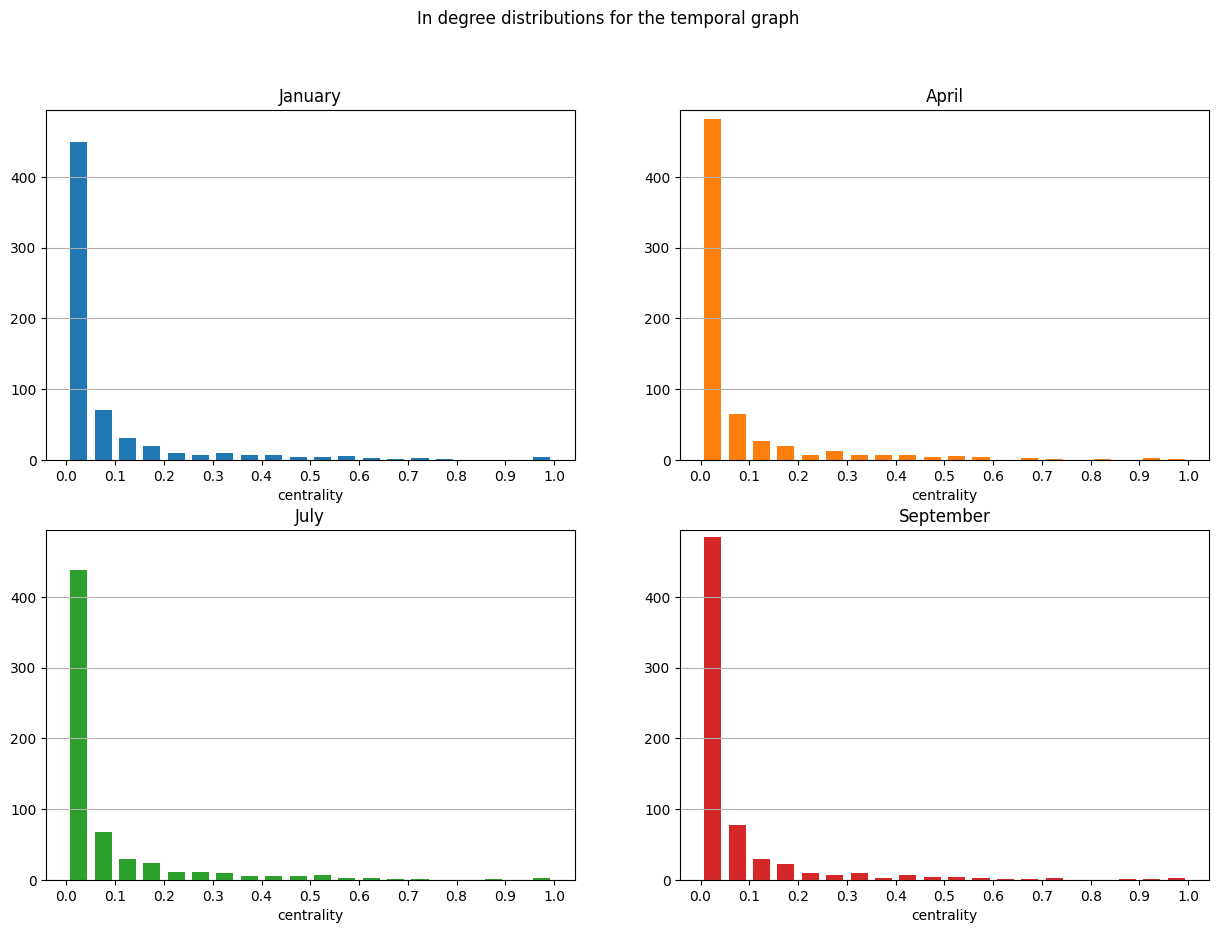

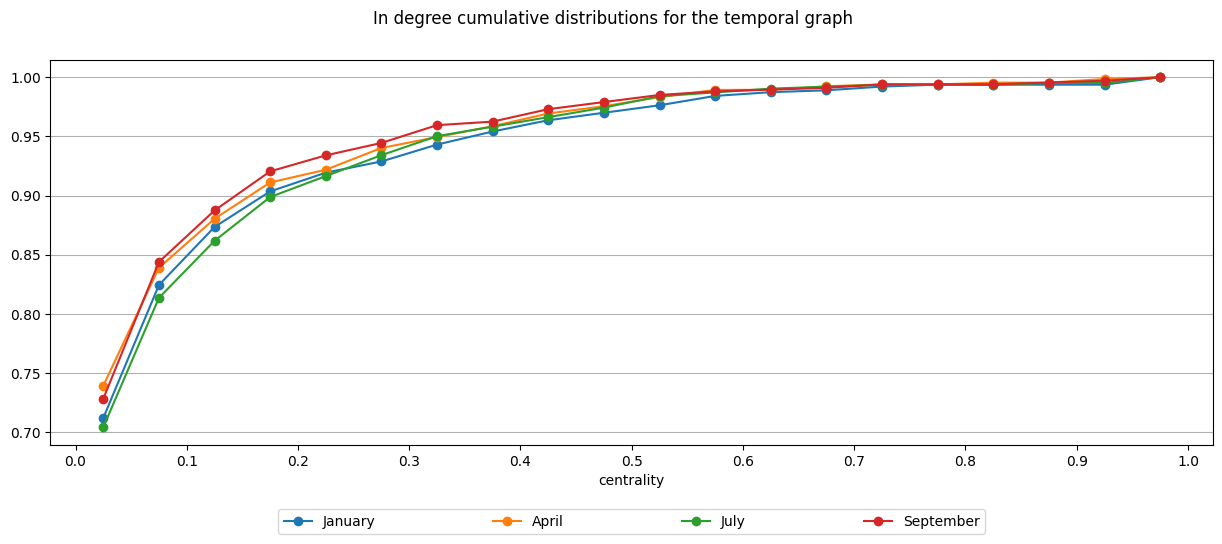

In [152]:
plot_temporal_network_centrality_distribution(month_in_degree_centralities, 'in degree', months_names)

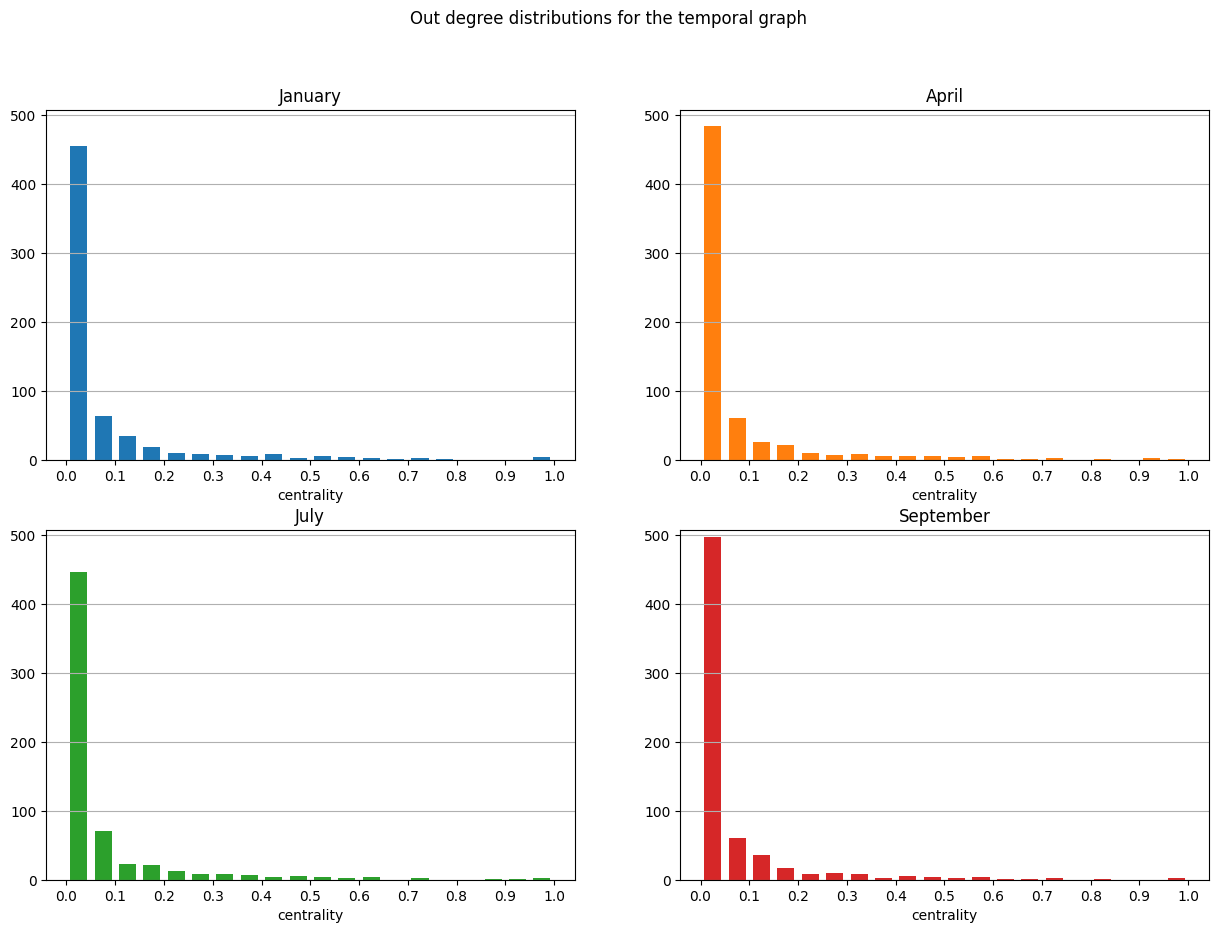

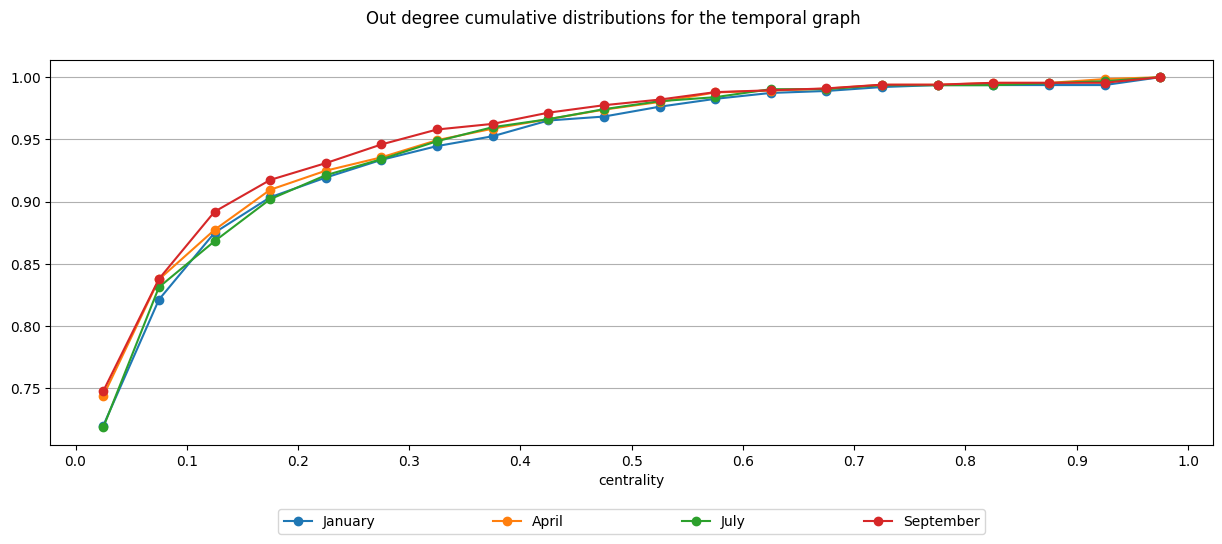

In [155]:
plot_temporal_network_centrality_distribution(month_out_degree_centralities, 'out degree', months_names)

In [160]:
weighted_in_degree_centralities = {}
i = 0
for month in analized_months:
    month_net = months_networks[month]
    month_in_degree_centrality = get_nodes_in_degree_centrality(month_net)
    weighted_in_degree_centralities[i] = weighted_average(month_in_degree_centrality, passengers_per_airport)
    i += 1

In [161]:
weighted_in_degree_centralities

{0: 0.5224196677534237,
 1: 0.48591183331609666,
 2: 0.49245451926749556,
 3: 0.47888065092769405}

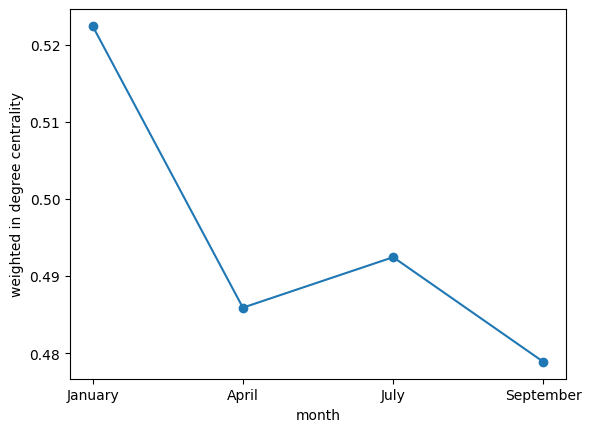

In [169]:
plt.plot(months_names, [weighted_in_degree_centralities[i] for i in weighted_in_degree_centralities], 'o-')
plt.xlabel('month')
plt.ylabel('weighted in degree centrality')
plt.show()

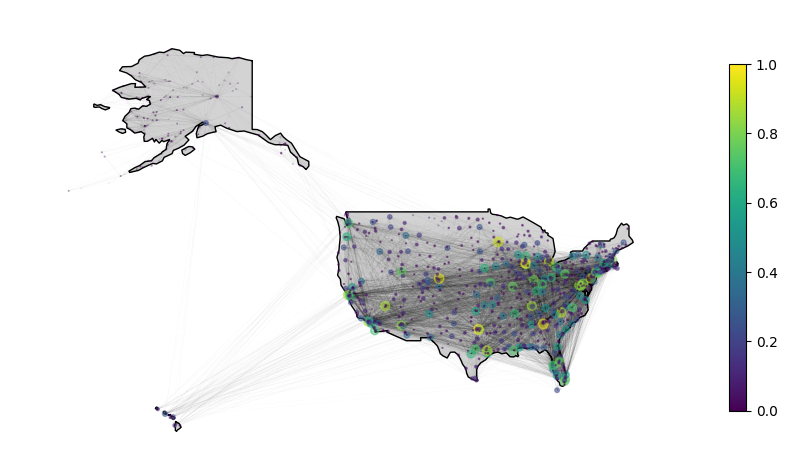

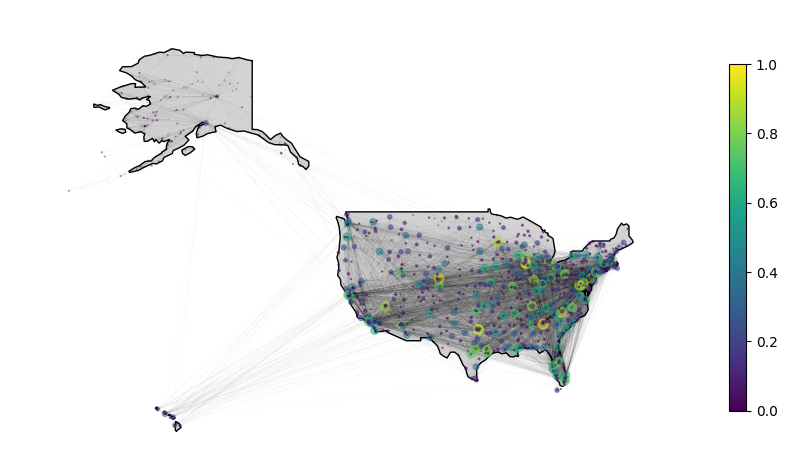

In [137]:
from metrics import get_nodes_hits_centrality

# get nodes in degree centrality for the network
hub_scores, auth_scores = get_nodes_hits_centrality(spatial_network, normalize=True)
hub_sizes = [hub_scores[iata] * 50 for iata in spatial_network.nodes]

fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(1, 2, 1)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=hub_sizes,
                 node_color=hub_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)

plt.show()

fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(1, 2, 1)

# get nodes in degree centrality for the network 
hub_sizes = [auth_scores[iata] * 50 for iata in spatial_network.nodes]


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=hub_sizes,
                 node_color=hub_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)

# Show the plot
plt.show()

In [234]:
iata_to_remove = 'ORD'
spatial_network.remove_node(iata_to_remove)

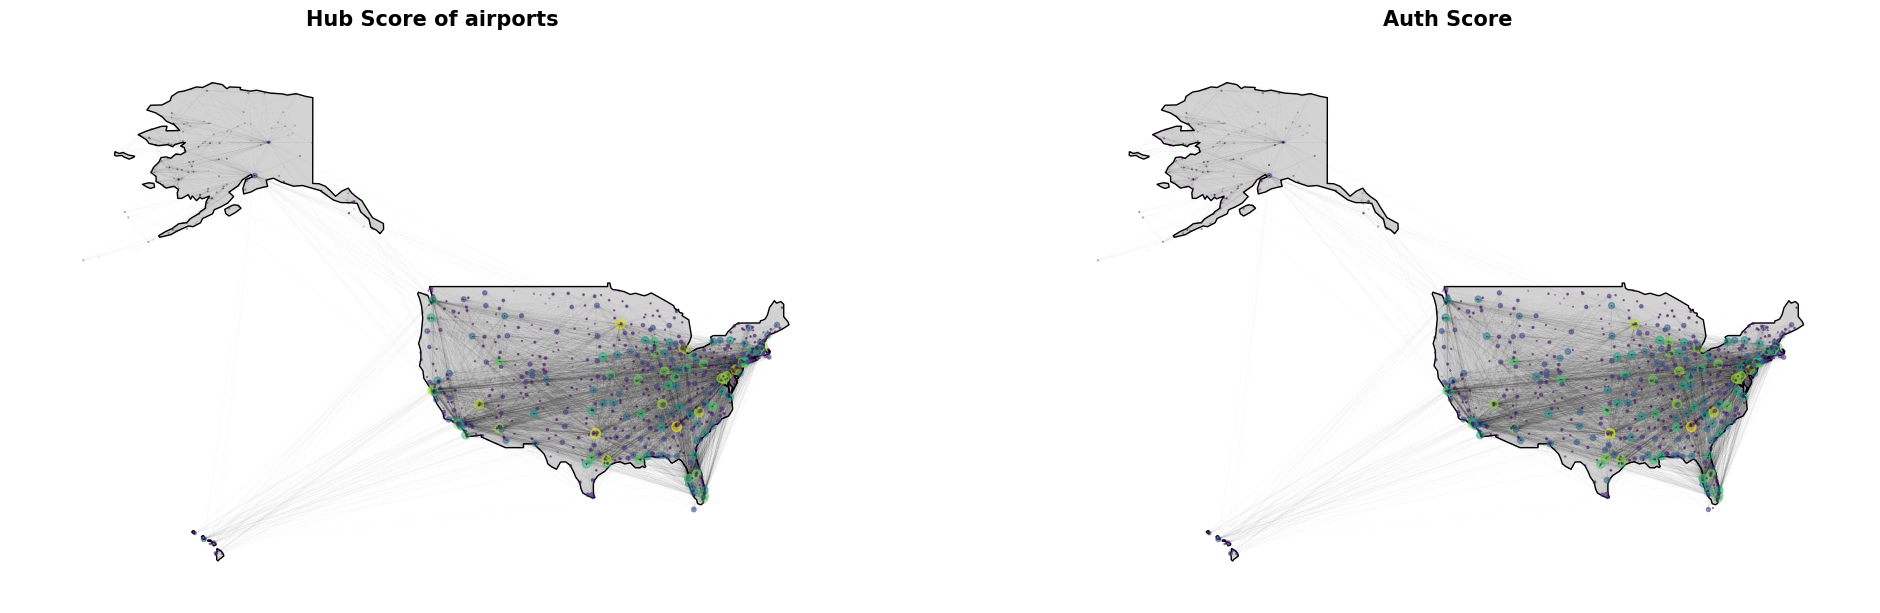

In [235]:
from metrics import get_nodes_hits_centrality

# get nodes in degree centrality for the network
hub_scores, auth_scores = get_nodes_hits_centrality(spatial_network, normalize=True)
hub_sizes = [hub_scores[iata] * 50 for iata in spatial_network.nodes]

fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(1, 2, 1)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=hub_sizes,
                 node_color=hub_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('Hub Score of airports', fontsize=15, fontweight='bold')

ax = fig.add_subplot(1, 2, 2)

# get nodes in degree centrality for the network 
hub_sizes = [auth_scores[iata] * 50 for iata in spatial_network.nodes]


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=hub_sizes,
                 node_color=hub_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('Auth Score', fontsize=15, fontweight='bold')

# Show the plot
plt.show()

In [242]:
spatial_network = weighted_net

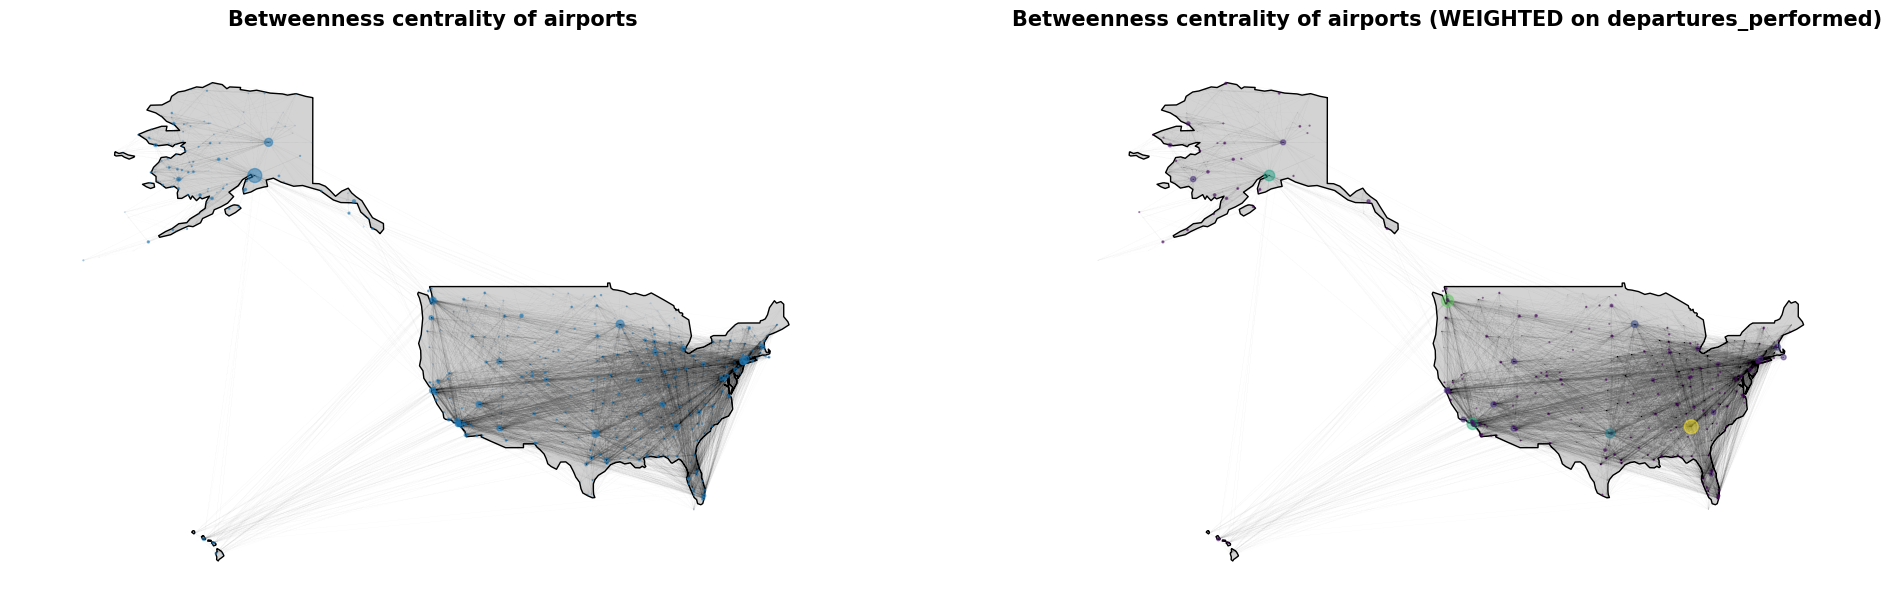

In [237]:
from metrics import get_nodes_betweenness_centrality
# get nodes in degree centrality for the network 
nodes_betweenness_centrality = get_nodes_betweenness_centrality(spatial_network)
betweenness_sizes = [nodes_betweenness_centrality[iata] * 100 for iata in spatial_network.nodes]

fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(1, 2, 1)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=betweenness_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('Betweenness centrality of airports', fontsize=15, fontweight='bold')

ax = fig.add_subplot(1, 2, 2)

# get nodes in degree centrality for the network 
nodes_betweenness_centrality_weighted = get_nodes_betweenness_centrality(spatial_network, weight='passengers_inv')
betweenness_sizes = [nodes_betweenness_centrality_weighted[iata] * 100 for iata in spatial_network.nodes]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')


nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=betweenness_sizes,
                 node_color=betweenness_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.get_cmap('viridis'))

# Customize the plot appearance
ax.set_axis_off()

plt.title('Betweenness centrality of airports (WEIGHTED on departures_performed)', fontsize=15, fontweight='bold')

# Show the plot
plt.show()

## Communities

In [36]:
from metrics import get_k_cores_communities

node_cores_dict = get_k_cores_communities(spatial_network)

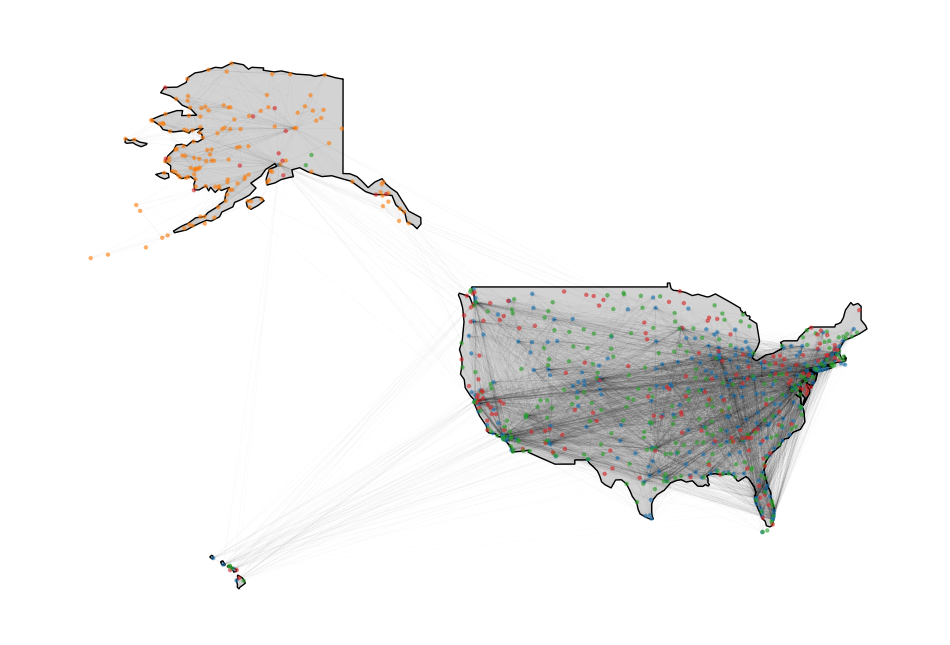

In [37]:
gray = (.5, .5, .5, 1)

# Map projection
fig, ax = plt.subplots(figsize=(12, 9))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter data for the United States
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

node_colors = [plt.cm.tab10(node_cores_dict[n]) if n in node_cores_dict.keys() else gray
                for n in spatial_network.nodes()]

nx.draw_networkx(spatial_network, 
                 ax=ax,
                 arrows=False,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=5,
                 node_color=node_colors,
                 labels=labels,
                 pos=pos,
                )

# Customize the plot appearance
ax.set_axis_off()

# Show the plot
plt.show()